In [1]:
import os
import onnx
import torch

model_dir = os.environ['FINN_ROOT'] + "/notebooks/end2end_example/cnn-dizeratie"
print("Model dir:", model_dir)
torch.set_num_threads(2)

Model dir: /home/stefan/finn/notebooks/end2end_example/cnn-dizeratie


In [2]:
!pip install kaggle

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.2/181.2 KB 739.3 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.2/78.2 KB 4.6 MB/s eta 0:00:00


In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# UTA RLDD

In [4]:
!mkdir -p data_uta_rldd
!kaggle datasets download -d minhngt02/uta-rldd -p data_uta_rldd --force
!ls data_uta_rldd

Dataset URL: https://www.kaggle.com/datasets/minhngt02/uta-rldd
License(s): CC0-1.0
100%|██████████████████████████████████████▉| 2.77G/2.77G [00:02<00:00, 730MB/s]
100%|███████████████████████████████████████| 2.77G/2.77G [00:03<00:00, 796MB/s]
UTA_RLDD_raw  uta-rldd.zip


In [5]:
!unzip -oq data_uta_rldd/uta-rldd.zip -d data_uta_rldd/UTA_RLDD_raw
print("Unzip completed.")

Unzip completed.


In [6]:
import os
import numpy as np
from torchvision import transforms
from torchvision.datasets import ImageFolder

# -------------------------------------------------------
# 1. Root folder where you unzipped the UTA-RLDD Kaggle dataset
#    Adjust this path to match your environment.
# -------------------------------------------------------
uta_root = "data_uta_rldd/UTA_RLDD_raw"   # <-- change if needed

train_root = os.path.join(uta_root, "train")
val_root   = os.path.join(uta_root, "val")
test_root  = os.path.join(uta_root, "test")

# -------------------------------------------------------
# 2. Transforms: resize to 128x128, tensor + normalization
# -------------------------------------------------------
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3),
])

# 2) No augmentation, only resize + normalize: VAL/TEST
eval_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5]),
])

# transform = transforms.Compose([
#     transforms.Resize((128, 128)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.5, 0.5, 0.5],
#                          std=[0.5, 0.5, 0.5]),
# ])

# transform = transforms.Compose([
#     transforms.Resize((128, 128)),
#     transforms.ToTensor(),
# ])

full_dataset = ImageFolder(root= os.path.join(uta_root, "train") , transform=transform)
# -------------------------------------------------------
# 3. Build train / val / test datasets from folders
# -------------------------------------------------------
train_quantized_dataset = ImageFolder(root=train_root, transform=transform)
val_quantized_dataset   = ImageFolder(root=val_root,   transform=eval_transform)
test_quantized_dataset  = ImageFolder(root=test_root,  transform=eval_transform)

print("Classes:", train_quantized_dataset.classes)
print("Train images:", len(train_quantized_dataset))
print("Val   images:", len(val_quantized_dataset))
print("Test  images:", len(test_quantized_dataset))

# Inspect one sample from train
x0, y0 = train_quantized_dataset[0]
print("Sample shape:", x0.shape)        # (3, 128, 128)
print("Sample label index:", y0)        # 0 or 1
print("Label name:", train_quantized_dataset.classes[y0])
print("Class names:", full_dataset.classes)

Classes: ['active', 'fatigue']
Train images: 9054
Val   images: 1824
Test  images: 909
Sample shape: torch.Size([3, 128, 128])
Sample label index: 0
Label name: active
Class names: ['active', 'fatigue']


In [ ]:
# BIG DATASET HOMEMADE

In [4]:
import os
import numpy as np
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split

# Root folder where the DDD images live
big_dataset_root = "big_dataset/DDD_UTA_RLDD_raw"

# -------------------------------------------------------
# 1. Transforms: resize to 128x128, tensor + normalization
# -------------------------------------------------------

transform = transforms.Compose([
    transforms.Resize((128, 128)),                          # resize a bit bigger
    transforms.RandomResizedCrop(128, scale=(0.85, 1.0), ratio=(0.9, 1.1)),
    transforms.RandomApply([
        transforms.ColorJitter(brightness=0.35, contrast=0.35,
                               saturation=0.15, hue=0.02)
    ], p=0.8),
    transforms.RandomApply([transforms.GaussianBlur(3, sigma=(0.1, 1.0))], p=0.2),
    transforms.RandomRotation(degrees=8),
    transforms.RandomHorizontalFlip(p=0.3),                 # optional; consider 0.0–0.3
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.08), ratio=(0.3, 3.3), value='random'),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3),
])

# Full dataset (no caching now!)
full_dataset = ImageFolder(root=big_dataset_root, transform=transform)

# -------------------------------------------------------
# 2. Build train / val / test datasets from folders
# -------------------------------------------------------

# Split into train / val / test
train_ratio = 0.6
train_size = int(train_ratio * len(full_dataset))
test_and_val_size = len(full_dataset) - train_size

val_ratio = 0.5 
val_size = int(val_ratio * test_and_val_size)
test_size = test_and_val_size - val_size

train_quantized_dataset, val_quantized_dataset, test_quantized_dataset = random_split(
    full_dataset, [train_size, val_size, test_size]
)

print("Classes:", full_dataset.classes)
print("Train images:", len(train_quantized_dataset))
print("Val   images:", len(val_quantized_dataset))
print("Test  images:", len(test_quantized_dataset))

# Inspect one sample from train
x0, y0 = train_quantized_dataset[0]
print("Sample shape:", x0.shape)        # (3, 128, 128)
print("Sample label index:", y0)        # 0 or 1
print("Label name:", full_dataset.classes[y0])
print("Class names:", full_dataset.classes)



Classes: ['Drowsy', 'Non Drowsy']
Train images: 32027
Val   images: 10676
Test  images: 10676
Sample shape: torch.Size([3, 128, 128])
Sample label index: 0
Label name: Drowsy
Class names: ['Drowsy', 'Non Drowsy']


Random TRAIN sample:


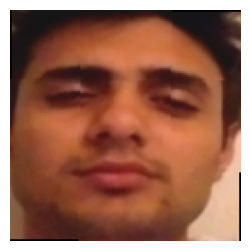

Title: Train sample
Label index: 0
--------------------------------------------------
Random VAL sample:


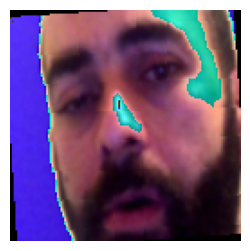

Title: Val sample
Label index: 0
--------------------------------------------------
Random TEST sample:


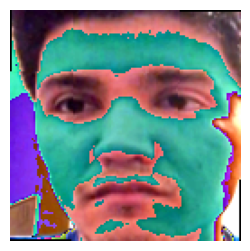

Title: Test sample
Label index: 0
--------------------------------------------------


In [5]:
import random
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

def show_random_sample_from_subset(subset, title):
    # subset is a torch.utils.data.Subset
    # subset.dataset is the underlying ImageFolder
    # subset.indices is the list of indices into the ImageFolder

    # pick a random index inside the subset
    subset_idx = random.randint(0, len(subset) - 1)
    # real_idx = subset.indices[subset_idx]   # index inside ImageFolder

    # get image + label
    img, label = subset[subset_idx]

    # get file path
    # filepath, _ = subset.dataset.samples[real_idx]

    # convert tensor to PIL for display
    img_pil = F.to_pil_image(img)

    plt.figure(figsize=(3, 3))
    plt.imshow(img_pil)
    # plt.title(f"{title}\nLabel: {subset.dataset.classes[label]}")
    plt.axis("off")
    plt.show()

    # also print details in text
    print(f"Title: {title}")
    print(f"Label index: {label}")
    # print(f"Label name: {subset.dataset.classes[label]}")
    # print(f"File path: {filepath}")
    print("--------------------------------------------------")


print("Random TRAIN sample:")
show_random_sample_from_subset(train_quantized_dataset, "Train sample")

print("Random VAL sample:")
show_random_sample_from_subset(val_quantized_dataset, "Val sample")

print("Random TEST sample:")
show_random_sample_from_subset(test_quantized_dataset, "Test sample")


In [6]:
from torch.utils.data import DataLoader

batch_size = 32   # safer for larger images; adjust later if needed

train_quantized_loader = DataLoader(
    train_quantized_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,      # try 4; reduce to 0 if errors
    pin_memory=False
)

test_quantized_loader = DataLoader(
    test_quantized_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=False
)

val_quantized_loader = DataLoader(
    val_quantized_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=False
)

In [7]:
count = 0
for x, y in train_quantized_loader:
    print("Input shape for 1 batch: " + str(x.shape))
    print("Label shape for 1 batch: " + str(y.shape))
    count += 1
    if count == 1:
        break

Input shape for 1 batch: torch.Size([32, 3, 128, 128])
Label shape for 1 batch: torch.Size([32])


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Target device: " + str(device))

Target device: cpu


In [9]:
num_classes = len(full_dataset.classes) 
print("Number of classes:", num_classes, "->", full_dataset.classes)

Number of classes: 2 -> ['Drowsy', 'Non Drowsy']


In [10]:
#### MODEL 6 #### 

from brevitas.nn import QuantConv2d, QuantLinear, QuantReLU
from brevitas.quant import Int8WeightPerTensorFixedPoint, Uint8ActPerTensorFixedPoint
import torch.nn as nn
import torch

torch.manual_seed(0)

class SmallKerasLikeQuantCNN(nn.Module):
    """
    Lighter version of the Keras-style model:
      Conv(16) + MaxPool
      Conv(32) + MaxPool
      Conv(32) + MaxPool
      Conv(32) + MaxPool
      Flatten -> Dropout(0.5) -> Dense(32) -> Dense(num_classes)
    """

    def __init__(self, num_classes=2, w_bit=4, a_bit=4,
                 input_height=128, input_width=128):
        super().__init__()

        # --------- Block 1: 3 -> 16 ---------
        self.conv1 = QuantConv2d(
            in_channels=3,
            out_channels=16,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=True,
            weight_bit_width=w_bit,
            weight_quant=Int8WeightPerTensorFixedPoint,
        )
        self.act1 = QuantReLU(
            bit_width=a_bit,
            act_quant=Uint8ActPerTensorFixedPoint,
            inplace=True,
        )
        self.pool1 = nn.MaxPool2d(2, 2)   # H,W: 128 -> 64

        # --------- Block 2: 16 -> 32 ---------
        self.conv2 = QuantConv2d(
            in_channels=16,
            out_channels=32,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=True,
            weight_bit_width=w_bit,
            weight_quant=Int8WeightPerTensorFixedPoint,
        )
        self.act2 = QuantReLU(
            bit_width=a_bit,
            act_quant=Uint8ActPerTensorFixedPoint,
            inplace=True,
        )
        self.pool2 = nn.MaxPool2d(2, 2)   # 64 -> 32

        # --------- Block 3: 32 -> 32 ---------
        self.conv3 = QuantConv2d(
            in_channels=32,
            out_channels=32,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=True,
            weight_bit_width=w_bit,
            weight_quant=Int8WeightPerTensorFixedPoint,
        )
        self.act3 = QuantReLU(
            bit_width=a_bit,
            act_quant=Uint8ActPerTensorFixedPoint,
            inplace=True,
        )
        self.pool3 = nn.MaxPool2d(2, 2)   # 32 -> 16

        # --------- Block 4: 32 -> 32 ---------
        self.conv4 = QuantConv2d(
            in_channels=32,
            out_channels=32,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=True,
            weight_bit_width=w_bit,
            weight_quant=Int8WeightPerTensorFixedPoint,
        )
        self.act4 = QuantReLU(
            bit_width=a_bit,
            act_quant=Uint8ActPerTensorFixedPoint,
            inplace=True,
        )
        self.pool4 = nn.MaxPool2d(2, 2)   # 16 -> 8

        # --------- Compute feature_dim automatically ---------
        with torch.no_grad():
            dummy = torch.zeros(1, 3, input_height, input_width)
            x = self.pool1(self.act1(self.conv1(dummy)))
            x = self.pool2(self.act2(self.conv2(x)))
            x = self.pool3(self.act3(self.conv3(x)))
            x = self.pool4(self.act4(self.conv4(x)))
            self.feature_dim = x.view(1, -1).shape[1]   # should be 32 * 8 * 8 = 2048 for 128x128

        # --------- Dropout + FC layers ---------
        self.dropout = nn.Dropout(p=0.5)

        self.fc1 = QuantLinear(
            in_features=self.feature_dim,
            out_features=32,   # smaller hidden layer
            bias=True,
            weight_bit_width=w_bit,
            weight_quant=Int8WeightPerTensorFixedPoint,
        )
        self.act_fc1 = QuantReLU(
            bit_width=a_bit,
            act_quant=Uint8ActPerTensorFixedPoint,
            inplace=True,
        )

        self.fc2 = QuantLinear(
            in_features=32,
            out_features=num_classes,   # 2 for drowsy/active
            bias=True,
            weight_bit_width=w_bit,
            weight_quant=Int8WeightPerTensorFixedPoint,
        )

    def forward(self, x):
        x = self.pool1(self.act1(self.conv1(x)))
        x = self.pool2(self.act2(self.conv2(x)))
        x = self.pool3(self.act3(self.conv3(x)))
        x = self.pool4(self.act4(self.conv4(x)))

        x = x.view(x.size(0), -1)   # flatten
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.act_fc1(x)
        x = self.fc2(x)             # logits
        return x

weight_bit_width = 4
act_bit_width    = 4
num_classes      = 2        # or 4 if your dataset has 4 labels
input_h, input_w = 128, 128 # or 145,145 if you change your Resize

# model = SmallKerasLikeQuantCNN(
#     num_classes=num_classes,
#     w_bit=weight_bit_width,
#     a_bit=act_bit_width,
#     input_height=input_h,
#     input_width=input_w,
# ).to(device)

# print(model)
# print("feature_dim:", model.feature_dim)

In [11]:
#############################
######## MODEL 6.1 ##########
#############################
from brevitas.nn import QuantConv2d, QuantLinear, QuantReLU
from brevitas.quant import Int8WeightPerTensorFixedPoint, Uint8ActPerTensorFixedPoint
import torch.nn as nn
import torch

torch.manual_seed(0)

class SmallKerasLikeQuantCNN_6_1(nn.Module):
    """
    Model 6.1:
      Conv(16) + MaxPool
      Conv(32) + MaxPool
      Conv(32) + MaxPool
      Conv(32) + MaxPool
      Flatten -> Dropout(0.3) -> FC(64) -> ReLU -> Dropout(0.3) -> FC(num_classes)
    """

    def __init__(self, name, num_classes=2, w_bit=4, a_bit=4,
                 input_height=128, input_width=128):
        super().__init__()
        self.name = name

        # Block 1: 3 -> 16, 128 -> 64
        self.conv1 = QuantConv2d(3, 16, 3, 1, 1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act1  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool1 = nn.MaxPool2d(2, 2)

        # Block 2: 16 -> 32, 64 -> 32
        self.conv2 = QuantConv2d(16, 32, 3, 1, 1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act2  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool2 = nn.MaxPool2d(2, 2)

        # Block 3: 32 -> 32, 32 -> 16
        self.conv3 = QuantConv2d(32, 32, 3, 1, 1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act3  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool3 = nn.MaxPool2d(2, 2)

        # Block 4: 32 -> 32, 16 -> 8
        self.conv4 = QuantConv2d(32, 32, 3, 1, 1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act4  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool4 = nn.MaxPool2d(2, 2)

        # feature dim
        with torch.no_grad():
            dummy = torch.zeros(1, 3, input_height, input_width)
            x = self.pool1(self.act1(self.conv1(dummy)))
            x = self.pool2(self.act2(self.conv2(x)))
            x = self.pool3(self.act3(self.conv3(x)))
            x = self.pool4(self.act4(self.conv4(x)))
            self.feature_dim = x.view(1, -1).shape[1]  # for 128: 32*8*8 = 2048

        # Head
        self.dropout    = nn.Dropout(p=0.3)
        self.fc1        = QuantLinear(self.feature_dim, 64, bias=True,
                                      weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act_fc1    = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.dropout_fc = nn.Dropout(p=0.3)
        self.fc2        = QuantLinear(64, num_classes, bias=True,
                                      weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self, x):
        x = self.pool1(self.act1(self.conv1(x)))
        x = self.pool2(self.act2(self.conv2(x)))
        x = self.pool3(self.act3(self.conv3(x)))
        x = self.pool4(self.act4(self.conv4(x)))

        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.act_fc1(x)
        x = self.dropout_fc(x)
        x = self.fc2(x)
        return x

weight_bit_width = 4
act_bit_width    = 4
num_classes      = 2        # or 4 if your dataset has 4 labels
input_h, input_w = 128, 128 # or 145,145 if you change your Resize

# model = SmallKerasLikeQuantCNN_6_1(
#     num_classes=num_classes,
#     w_bit=weight_bit_width,
#     a_bit=act_bit_width,
#     input_height=128,
#     input_width=128
# ).to(device)

# print(model.name)
# print("feature_dim:", model.feature_dim)


In [12]:
#############################
######## MODEL 6.2 ##########
#############################
from brevitas.nn import QuantConv2d, QuantLinear, QuantReLU
from brevitas.quant import Int8WeightPerTensorFixedPoint, Uint8ActPerTensorFixedPoint
import torch.nn as nn
import torch

torch.manual_seed(0)

class SmallKerasLikeQuantCNN_6_2(nn.Module):
    """
    Model 6.2:
      Conv(16) + MaxPool
      Conv(32) + MaxPool
      Conv(48) + MaxPool
      Conv(64) + MaxPool
      Flatten -> Dropout(0.3) -> FC(64) -> ReLU -> Dropout(0.3) -> FC(num_classes)
    """

    def __init__(self, name, num_classes=2, w_bit=4, a_bit=4,
                 input_height=128, input_width=128):
        super().__init__()
        self.name = name

        # Block 1: 3 -> 16, 128 -> 64
        self.conv1 = QuantConv2d(3, 16, 3, 1, 1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act1  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool1 = nn.MaxPool2d(2, 2)

        # Block 2: 16 -> 32, 64 -> 32
        self.conv2 = QuantConv2d(16, 32, 3, 1, 1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act2  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool2 = nn.MaxPool2d(2, 2)

        # Block 3: 32 -> 48, 32 -> 16
        self.conv3 = QuantConv2d(32, 48, 3, 1, 1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act3  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool3 = nn.MaxPool2d(2, 2)

        # Block 4: 48 -> 64, 16 -> 8
        self.conv4 = QuantConv2d(48, 64, 3, 1, 1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act4  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool4 = nn.MaxPool2d(2, 2)

        with torch.no_grad():
            dummy = torch.zeros(1, 3, input_height, input_width)
            x = self.pool1(self.act1(self.conv1(dummy)))
            x = self.pool2(self.act2(self.conv2(x)))
            x = self.pool3(self.act3(self.conv3(x)))
            x = self.pool4(self.act4(self.conv4(x)))
            self.feature_dim = x.view(1, -1).shape[1]  # 64*8*8 = 4096

        self.dropout    = nn.Dropout(p=0.3)
        self.fc1        = QuantLinear(self.feature_dim, 64, bias=True,
                                      weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act_fc1    = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.dropout_fc = nn.Dropout(p=0.3)
        self.fc2        = QuantLinear(64, num_classes, bias=True,
                                      weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self, x):
        x = self.pool1(self.act1(self.conv1(x)))
        x = self.pool2(self.act2(self.conv2(x)))
        x = self.pool3(self.act3(self.conv3(x)))
        x = self.pool4(self.act4(self.conv4(x)))

        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.act_fc1(x)
        x = self.dropout_fc(x)
        x = self.fc2(x)
        return x

weight_bit_width = 4
act_bit_width    = 4
num_classes      = 2        # or 4 if your dataset has 4 labels
input_h, input_w = 128, 128 # or 145,145 if you change your Resize

# model = SmallKerasLikeQuantCNN_6_2(
#     num_classes=num_classes,
#     w_bit=weight_bit_width,
#     a_bit=act_bit_width,
#     input_height=128,
#     input_width=128
# ).to(device)

# print(model)
# print("feature_dim:", model.feature_dim)


In [13]:
#############################
######## MODEL 6.3 ##########
#############################
from brevitas.nn import QuantConv2d, QuantLinear, QuantReLU
from brevitas.quant import Int8WeightPerTensorFixedPoint, Uint8ActPerTensorFixedPoint
import torch.nn as nn
import torch

torch.manual_seed(0)

class SmallKerasLikeQuantCNN_6_3(nn.Module):
    """
    Model 6.3:
      Same as Model 6 conv widths, but adds Dropout2d(p=0.1) in the conv trunk
      (training-only) + head like 6.1.
    """

    def __init__(self, name, num_classes=2, w_bit=4, a_bit=4,
                 input_height=128, input_width=128):
        super().__init__()
        self.name = name

        # Block 1: 3 -> 16, 128 -> 64
        self.conv1 = QuantConv2d(3, 16, 3, 1, 1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act1  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool1 = nn.MaxPool2d(2, 2)

        # Block 2: 16 -> 32, 64 -> 32
        self.conv2 = QuantConv2d(16, 32, 3, 1, 1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act2  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool2 = nn.MaxPool2d(2, 2)

        # Dropout2d in trunk (training-only)
        self.drop2 = nn.Dropout2d(p=0.1)

        # Block 3: 32 -> 32, 32 -> 16
        self.conv3 = QuantConv2d(32, 32, 3, 1, 1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act3  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.drop3 = nn.Dropout2d(p=0.1)

        # Block 4: 32 -> 32, 16 -> 8
        self.conv4 = QuantConv2d(32, 32, 3, 1, 1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act4  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool4 = nn.MaxPool2d(2, 2)

        with torch.no_grad():
            dummy = torch.zeros(1, 3, input_height, input_width)
            x = self.pool1(self.act1(self.conv1(dummy)))
            x = self.pool2(self.act2(self.conv2(x)))
            x = self.drop2(x)
            x = self.pool3(self.act3(self.conv3(x)))
            x = self.drop3(x)
            x = self.pool4(self.act4(self.conv4(x)))
            self.feature_dim = x.view(1, -1).shape[1]  # 32*8*8 = 2048

        self.dropout    = nn.Dropout(p=0.3)
        self.fc1        = QuantLinear(self.feature_dim, 64, bias=True,
                                      weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act_fc1    = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.dropout_fc = nn.Dropout(p=0.3)
        self.fc2        = QuantLinear(64, num_classes, bias=True,
                                      weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self, x):
        x = self.pool1(self.act1(self.conv1(x)))
        x = self.pool2(self.act2(self.conv2(x)))
        x = self.drop2(x)
        x = self.pool3(self.act3(self.conv3(x)))
        x = self.drop3(x)
        x = self.pool4(self.act4(self.conv4(x)))

        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.act_fc1(x)
        x = self.dropout_fc(x)
        x = self.fc2(x)
        return x

weight_bit_width = 4
act_bit_width    = 4
num_classes      = 2        # or 4 if your dataset has 4 labels
input_h, input_w = 128, 128 # or 145,145 if you change your Resize

# model = SmallKerasLikeQuantCNN_6_3(
#     num_classes=num_classes,
#     w_bit=weight_bit_width,
#     a_bit=act_bit_width,
#     input_height=128,
#     input_width=128
# ).to(device)

# print(model)
# print("feature_dim:", model.feature_dim)


In [14]:
### Model 8 ### 

from brevitas.nn import QuantConv2d, QuantLinear, QuantReLU
from brevitas.quant import Int8WeightPerTensorFixedPoint, Uint8ActPerTensorFixedPoint
import torch.nn as nn
import torch

torch.manual_seed(0)

class Model8_Bottleneck1x1(nn.Module):
    def __init__(self, num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()

        # Block 1: 3 -> 16 -> (1x1) -> 8, pool
        self.conv1 = QuantConv2d(3, 16, 3, 1, 1, bias=True, weight_bit_width=w_bit,
                                 weight_quant=Int8WeightPerTensorFixedPoint)
        self.act1  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.conv1b = QuantConv2d(16, 8, 1, 1, 0, bias=True, weight_bit_width=w_bit,
                                  weight_quant=Int8WeightPerTensorFixedPoint)
        self.act1b  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool1 = nn.MaxPool2d(2, 2)  # 128->64

        # Block 2: 8 -> 16 -> (1x1) -> 16, pool
        self.conv2 = QuantConv2d(8, 16, 3, 1, 1, bias=True, weight_bit_width=w_bit,
                                 weight_quant=Int8WeightPerTensorFixedPoint)
        self.act2  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.conv2b = QuantConv2d(16, 16, 1, 1, 0, bias=True, weight_bit_width=w_bit,
                                  weight_quant=Int8WeightPerTensorFixedPoint)
        self.act2b  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool2 = nn.MaxPool2d(2, 2)  # 64->32

        # Block 3: 16 -> 32, pool
        self.conv3 = QuantConv2d(16, 32, 3, 1, 1, bias=True, weight_bit_width=w_bit,
                                 weight_quant=Int8WeightPerTensorFixedPoint)
        self.act3  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool3 = nn.MaxPool2d(2, 2)  # 32->16

        with torch.no_grad():
            dummy = torch.zeros(1, 3, input_height, input_width)
            x = self.pool1(self.act1b(self.conv1b(self.act1(self.conv1(dummy)))))
            x = self.pool2(self.act2b(self.conv2b(self.act2(self.conv2(x)))))
            x = self.pool3(self.act3(self.conv3(x)))
            self.feature_dim = x.view(1, -1).shape[1]

        self.fc1 = QuantLinear(self.feature_dim, 64, bias=True, weight_bit_width=w_bit,
                               weight_quant=Int8WeightPerTensorFixedPoint)
        self.act_fc1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.fc2 = QuantLinear(64, num_classes, bias=True, weight_bit_width=w_bit,
                               weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self, x):
        x = self.pool1(self.act1b(self.conv1b(self.act1(self.conv1(x)))))
        x = self.pool2(self.act2b(self.conv2b(self.act2(self.conv2(x)))))
        x = self.pool3(self.act3(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = self.act_fc1(self.fc1(x))
        x = self.fc2(x)
        return x


In [15]:
### Model 9 ### 
class Model9_VGGLite(nn.Module):
    def __init__(self, num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()

        # Stage 1: 3 -> 16 -> 16, pool (128->64)
        self.c1 = QuantConv2d(3, 16, 3, 1, 1, bias=True, weight_bit_width=w_bit,
                              weight_quant=Int8WeightPerTensorFixedPoint)
        self.a1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.c1b = QuantConv2d(16, 16, 3, 1, 1, bias=True, weight_bit_width=w_bit,
                               weight_quant=Int8WeightPerTensorFixedPoint)
        self.a1b = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p1 = nn.MaxPool2d(2,2)

        # Stage 2: 16 -> 32 -> 32, pool (64->32)
        self.c2 = QuantConv2d(16, 32, 3, 1, 1, bias=True, weight_bit_width=w_bit,
                              weight_quant=Int8WeightPerTensorFixedPoint)
        self.a2 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.c2b = QuantConv2d(32, 32, 3, 1, 1, bias=True, weight_bit_width=w_bit,
                               weight_quant=Int8WeightPerTensorFixedPoint)
        self.a2b = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p2 = nn.MaxPool2d(2,2)

        # Stage 3: 32 -> 48, pool (32->16)
        self.c3 = QuantConv2d(32, 48, 3, 1, 1, bias=True, weight_bit_width=w_bit,
                              weight_quant=Int8WeightPerTensorFixedPoint)
        self.a3 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p3 = nn.MaxPool2d(2,2)

        with torch.no_grad():
            dummy = torch.zeros(1, 3, input_height, input_width)
            x = self.p1(self.a1b(self.c1b(self.a1(self.c1(dummy)))))
            x = self.p2(self.a2b(self.c2b(self.a2(self.c2(x)))))
            x = self.p3(self.a3(self.c3(x)))
            self.feature_dim = x.view(1, -1).shape[1]

        self.fc1 = QuantLinear(self.feature_dim, 64, bias=True, weight_bit_width=w_bit,
                               weight_quant=Int8WeightPerTensorFixedPoint)
        self.act_fc1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.fc2 = QuantLinear(64, num_classes, bias=True, weight_bit_width=w_bit,
                               weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self, x):
        x = self.p1(self.a1b(self.c1b(self.a1(self.c1(x)))))
        x = self.p2(self.a2b(self.c2b(self.a2(self.c2(x)))))
        x = self.p3(self.a3(self.c3(x)))
        x = x.view(x.size(0), -1)
        x = self.act_fc1(self.fc1(x))
        x = self.fc2(x)
        return x


In [16]:
### Model 10 ###
class Model10_MorePooling(nn.Module):
    def __init__(self, num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()

        self.c1 = QuantConv2d(3, 16, 3, 1, 1, bias=True, weight_bit_width=w_bit,
                              weight_quant=Int8WeightPerTensorFixedPoint)
        self.a1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p1 = nn.MaxPool2d(2,2)  # 128->64

        self.c2 = QuantConv2d(16, 32, 3, 1, 1, bias=True, weight_bit_width=w_bit,
                              weight_quant=Int8WeightPerTensorFixedPoint)
        self.a2 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p2 = nn.MaxPool2d(2,2)  # 64->32

        self.c3 = QuantConv2d(32, 32, 3, 1, 1, bias=True, weight_bit_width=w_bit,
                              weight_quant=Int8WeightPerTensorFixedPoint)
        self.a3 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p3 = nn.MaxPool2d(2,2)  # 32->16

        self.c4 = QuantConv2d(32, 32, 3, 1, 1, bias=True, weight_bit_width=w_bit,
                              weight_quant=Int8WeightPerTensorFixedPoint)
        self.a4 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p4 = nn.MaxPool2d(2,2)  # 16->8

        self.c5 = QuantConv2d(32, 32, 3, 1, 1, bias=True, weight_bit_width=w_bit,
                              weight_quant=Int8WeightPerTensorFixedPoint)
        self.a5 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p5 = nn.MaxPool2d(2,2)  # 8->4  (this is the point)

        with torch.no_grad():
            dummy = torch.zeros(1, 3, input_height, input_width)
            x = self.p1(self.a1(self.c1(dummy)))
            x = self.p2(self.a2(self.c2(x)))
            x = self.p3(self.a3(self.c3(x)))
            x = self.p4(self.a4(self.c4(x)))
            x = self.p5(self.a5(self.c5(x)))
            self.feature_dim = x.view(1, -1).shape[1]  # 32*4*4 = 512

        self.fc1 = QuantLinear(self.feature_dim, 64, bias=True, weight_bit_width=w_bit,
                               weight_quant=Int8WeightPerTensorFixedPoint)
        self.act_fc1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.fc2 = QuantLinear(64, num_classes, bias=True, weight_bit_width=w_bit,
                               weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self, x):
        x = self.p1(self.a1(self.c1(x)))
        x = self.p2(self.a2(self.c2(x)))
        x = self.p3(self.a3(self.c3(x)))
        x = self.p4(self.a4(self.c4(x)))
        x = self.p5(self.a5(self.c5(x)))
        x = x.view(x.size(0), -1)
        x = self.act_fc1(self.fc1(x))
        x = self.fc2(x)
        return x


In [17]:
### Model 11 ### 
class Model11_CappedChannels(nn.Module):
    def __init__(self, num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()

        self.c1 = QuantConv2d(3, 12, 3, 1, 1, bias=True, weight_bit_width=w_bit,
                              weight_quant=Int8WeightPerTensorFixedPoint)
        self.a1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p1 = nn.MaxPool2d(2,2)

        self.c2 = QuantConv2d(12, 24, 3, 1, 1, bias=True, weight_bit_width=w_bit,
                              weight_quant=Int8WeightPerTensorFixedPoint)
        self.a2 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p2 = nn.MaxPool2d(2,2)

        self.c3 = QuantConv2d(24, 24, 3, 1, 1, bias=True, weight_bit_width=w_bit,
                              weight_quant=Int8WeightPerTensorFixedPoint)
        self.a3 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p3 = nn.MaxPool2d(2,2)

        self.c4 = QuantConv2d(24, 32, 3, 1, 1, bias=True, weight_bit_width=w_bit,
                              weight_quant=Int8WeightPerTensorFixedPoint)
        self.a4 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p4 = nn.MaxPool2d(2,2)  # 128->64->32->16->8

        with torch.no_grad():
            dummy = torch.zeros(1, 3, input_height, input_width)
            x = self.p1(self.a1(self.c1(dummy)))
            x = self.p2(self.a2(self.c2(x)))
            x = self.p3(self.a3(self.c3(x)))
            x = self.p4(self.a4(self.c4(x)))
            self.feature_dim = x.view(1, -1).shape[1]  # 32*8*8 = 2048

        self.fc1 = QuantLinear(self.feature_dim, 32, bias=True, weight_bit_width=w_bit,
                               weight_quant=Int8WeightPerTensorFixedPoint)
        self.act_fc1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.fc2 = QuantLinear(32, num_classes, bias=True, weight_bit_width=w_bit,
                               weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self, x):
        x = self.p1(self.a1(self.c1(x)))
        x = self.p2(self.a2(self.c2(x)))
        x = self.p3(self.a3(self.c3(x)))
        x = self.p4(self.a4(self.c4(x)))
        x = x.view(x.size(0), -1)
        x = self.act_fc1(self.fc1(x))
        x = self.fc2(x)
        return x


In [18]:
### Model 12 ###

class Model12_ShrinkBeforeFC(nn.Module):
    def __init__(self, num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()
        
        self.c1 = QuantConv2d(3, 16, 3, 1, 1, bias=True, weight_bit_width=w_bit,
                              weight_quant=Int8WeightPerTensorFixedPoint)
        self.a1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p1 = nn.MaxPool2d(2,2)  # 128->64

        self.c2 = QuantConv2d(16, 32, 3, 1, 1, bias=True, weight_bit_width=w_bit,
                              weight_quant=Int8WeightPerTensorFixedPoint)
        self.a2 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p2 = nn.MaxPool2d(2,2)  # 64->32

        self.c3 = QuantConv2d(32, 48, 3, 1, 1, bias=True, weight_bit_width=w_bit,
                              weight_quant=Int8WeightPerTensorFixedPoint)
        self.a3 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p3 = nn.MaxPool2d(2,2)  # 32->16

        # 1x1 squeeze: 48 -> 16 (cheap)
        self.squeeze = QuantConv2d(48, 16, 1, 1, 0, bias=True, weight_bit_width=w_bit,
                                   weight_quant=Int8WeightPerTensorFixedPoint)
        self.a_sq = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p4 = nn.MaxPool2d(2,2)  # 16->8

        with torch.no_grad():
            dummy = torch.zeros(1, 3, input_height, input_width)
            x = self.p1(self.a1(self.c1(dummy)))
            x = self.p2(self.a2(self.c2(x)))
            x = self.p3(self.a3(self.c3(x)))
            x = self.p4(self.a_sq(self.squeeze(x)))
            self.feature_dim = x.view(1, -1).shape[1]  # 16*8*8 = 1024

        self.fc1 = QuantLinear(self.feature_dim, 64, bias=True, weight_bit_width=w_bit,
                               weight_quant=Int8WeightPerTensorFixedPoint)
        self.act_fc1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.fc2 = QuantLinear(64, num_classes, bias=True, weight_bit_width=w_bit,
                               weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self, x):
        x = self.p1(self.a1(self.c1(x)))
        x = self.p2(self.a2(self.c2(x)))
        x = self.p3(self.a3(self.c3(x)))
        x = self.p4(self.a_sq(self.squeeze(x)))
        x = x.view(x.size(0), -1)
        x = self.act_fc1(self.fc1(x))
        x = self.fc2(x)
        return x


In [19]:
from brevitas.nn import QuantConv2d, QuantLinear, QuantReLU
from brevitas.quant import Int8WeightPerTensorFixedPoint, Uint8ActPerTensorFixedPoint
import torch.nn as nn
import torch


In [20]:
class Model13_VGGmini(nn.Module):
    def __init__(self, num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()

        self.conv1 = QuantConv2d(
            in_channels=3,
            out_channels=16,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=True,
            groups=1,
            weight_bit_width=w_bit,
            weight_quant=Int8WeightPerTensorFixedPoint,
        )
        self.act1 = QuantReLU(
            bit_width=a_bit,
            act_quant=Uint8ActPerTensorFixedPoint,
            inplace=True,
        )
        self.pool1 = nn.MaxPool2d(2, 2)   # 128->64

        self.conv2 = QuantConv2d(
            in_channels=16,
            out_channels=32,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=True,
            groups=1,
            weight_bit_width=w_bit,
            weight_quant=Int8WeightPerTensorFixedPoint,
        )
        self.act2 = QuantReLU(
            bit_width=a_bit,
            act_quant=Uint8ActPerTensorFixedPoint,
            inplace=True,
        )
        self.pool2 = nn.MaxPool2d(2, 2)   # 64->32

        self.conv3 = QuantConv2d(
            in_channels=32,
            out_channels=64,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=True,
            groups=1,
            weight_bit_width=w_bit,
            weight_quant=Int8WeightPerTensorFixedPoint,
        )
        self.act3 = QuantReLU(
            bit_width=a_bit,
            act_quant=Uint8ActPerTensorFixedPoint,
            inplace=True,
        )
        self.pool3 = nn.MaxPool2d(2, 2)   # 32->16

        with torch.no_grad():
            d = torch.zeros(1, 3, input_height, input_width)
            x = self.pool1(self.act1(self.conv1(d)))
            x = self.pool2(self.act2(self.conv2(x)))
            x = self.pool3(self.act3(self.conv3(x)))
            self.feature_dim = x.view(1, -1).shape[1]

        self.fc1 = QuantLinear(
            in_features=self.feature_dim,
            out_features=64,
            bias=True,
            weight_bit_width=w_bit,
            weight_quant=Int8WeightPerTensorFixedPoint,
        )
        self.act_fc1 = QuantReLU(
            bit_width=a_bit,
            act_quant=Uint8ActPerTensorFixedPoint,
            inplace=True,
        )
        self.fc2 = QuantLinear(
            in_features=64,
            out_features=num_classes,
            bias=True,
            weight_bit_width=w_bit,
            weight_quant=Int8WeightPerTensorFixedPoint,
        )

    def forward(self, x):
        x = self.pool1(self.act1(self.conv1(x)))
        x = self.pool2(self.act2(self.conv2(x)))
        x = self.pool3(self.act3(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = self.act_fc1(self.fc1(x))
        return self.fc2(x)


In [21]:
class Model14_VGGmini_morepool(nn.Module):
    def __init__(self, num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()
        self.conv1 = QuantConv2d(
            in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1, bias=True,
            weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint
        )
        self.act1  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool1 = nn.MaxPool2d(2, 2)   # 128->64

        self.conv2 = QuantConv2d(
            in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1, bias=True,
            weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint
        )
        self.act2  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool2 = nn.MaxPool2d(2, 2)   # 64->32

        self.conv3 = QuantConv2d(
            in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1, bias=True,
            weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint
        )
        self.act3  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool3 = nn.MaxPool2d(2, 2)   # 32->16

        self.pool4 = nn.MaxPool2d(2, 2)   # 16->8

        with torch.no_grad():
            d = torch.zeros(1, 3, input_height, input_width)
            x = self.pool1(self.act1(self.conv1(d)))
            x = self.pool2(self.act2(self.conv2(x)))
            x = self.pool3(self.act3(self.conv3(x)))
            x = self.pool4(x)
            self.feature_dim = x.view(1, -1).shape[1]

        self.fc1 = QuantLinear(
            in_features=self.feature_dim, out_features=64, bias=True,
            weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint
        )
        self.act_fc1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.fc2 = QuantLinear(
            in_features=64, out_features=num_classes, bias=True,
            weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint
        )

    def forward(self, x):
        x = self.pool1(self.act1(self.conv1(x)))
        x = self.pool2(self.act2(self.conv2(x)))
        x = self.pool3(self.act3(self.conv3(x)))
        x = self.pool4(x)
        x = x.view(x.size(0), -1)
        x = self.act_fc1(self.fc1(x))
        return self.fc2(x)


In [22]:
class Model15_2conv_stages(nn.Module):
    def __init__(self, num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()

        # Stage 1
        self.c11 = QuantConv2d(
            in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1, bias=True,
            groups=1,
            weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint
        )
        self.a11 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)

        self.c12 = QuantConv2d(
            in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1, bias=True,
            groups=1,
            weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint
        )
        self.a12 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p1 = nn.MaxPool2d(2, 2)  # 128 -> 64

        # Stage 2
        self.c21 = QuantConv2d(
            in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1, bias=True,
            groups=1,
            weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint
        )
        self.a21 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)

        self.c22 = QuantConv2d(
            in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1, bias=True,
            groups=1,
            weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint
        )
        self.a22 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p2 = nn.MaxPool2d(2, 2)  # 64 -> 32

        # Stage 3
        self.c31 = QuantConv2d(
            in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1, bias=True,
            groups=1,
            weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint
        )
        self.a31 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p3 = nn.MaxPool2d(2, 2)  # 32 -> 16

        # feature_dim
        with torch.no_grad():
            d = torch.zeros(1, 3, input_height, input_width)
            x = self.p1(self.a12(self.c12(self.a11(self.c11(d)))))
            x = self.p2(self.a22(self.c22(self.a21(self.c21(x)))))
            x = self.p3(self.a31(self.c31(x)))
            self.feature_dim = x.view(1, -1).shape[1]

        # head
        self.fc1 = QuantLinear(
            in_features=self.feature_dim, out_features=64, bias=True,
            weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint
        )
        self.act_fc1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.fc2 = QuantLinear(
            in_features=64, out_features=num_classes, bias=True,
            weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint
        )

    def forward(self, x):
        x = self.p1(self.a12(self.c12(self.a11(self.c11(x)))))
        x = self.p2(self.a22(self.c22(self.a21(self.c21(x)))))
        x = self.p3(self.a31(self.c31(x)))
        x = x.view(x.size(0), -1)
        x = self.act_fc1(self.fc1(x))
        return self.fc2(x)



In [23]:
class Model16_wide_early(nn.Module):
    def __init__(self, num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()
        self.conv1 = QuantConv2d(
            in_channels=3, out_channels=24, kernel_size=3, stride=1, padding=1, bias=True,
            weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint
        )
        self.act1  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = QuantConv2d(
            in_channels=24, out_channels=32, kernel_size=3, stride=1, padding=1, bias=True,
            weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint
        )
        self.act2  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv3 = QuantConv2d(
            in_channels=32, out_channels=48, kernel_size=3, stride=1, padding=1, bias=True,
            weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint
        )
        self.act3  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.pool4 = nn.MaxPool2d(2, 2)  # -> 8x8

        with torch.no_grad():
            d = torch.zeros(1, 3, input_height, input_width)
            x = self.pool1(self.act1(self.conv1(d)))
            x = self.pool2(self.act2(self.conv2(x)))
            x = self.pool3(self.act3(self.conv3(x)))
            x = self.pool4(x)
            self.feature_dim = x.view(1, -1).shape[1]

        self.fc1 = QuantLinear(
            in_features=self.feature_dim, out_features=64, bias=True,
            weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint
        )
        self.act_fc1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.fc2 = QuantLinear(
            in_features=64, out_features=num_classes, bias=True,
            weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint
        )

    def forward(self, x):
        x = self.pool1(self.act1(self.conv1(x)))
        x = self.pool2(self.act2(self.conv2(x)))
        x = self.pool3(self.act3(self.conv3(x)))
        x = self.pool4(x)
        x = x.view(x.size(0), -1)
        x = self.act_fc1(self.fc1(x))
        return self.fc2(x)


In [24]:
class Model17_deeper_4blocks(nn.Module):
    def __init__(self, num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()
        self.conv1 = QuantConv2d(3, 16, 3, stride=1, padding=1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act1  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = QuantConv2d(16, 32, 3, stride=1, padding=1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act2  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv3 = QuantConv2d(32, 64, 3, stride=1, padding=1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act3  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.conv4 = QuantConv2d(64, 64, 3, stride=1, padding=1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act4  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool4 = nn.MaxPool2d(2, 2)

        with torch.no_grad():
            d = torch.zeros(1, 3, input_height, input_width)
            x = self.pool1(self.act1(self.conv1(d)))
            x = self.pool2(self.act2(self.conv2(x)))
            x = self.pool3(self.act3(self.conv3(x)))
            x = self.pool4(self.act4(self.conv4(x)))
            self.feature_dim = x.view(1, -1).shape[1]

        self.fc = QuantLinear(
            in_features=self.feature_dim, out_features=num_classes, bias=True,
            weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint
        )

    def forward(self, x):
        x = self.pool1(self.act1(self.conv1(x)))
        x = self.pool2(self.act2(self.conv2(x)))
        x = self.pool3(self.act3(self.conv3(x)))
        x = self.pool4(self.act4(self.conv4(x)))
        x = x.view(x.size(0), -1)
        return self.fc(x)


In [25]:
class Model18_bigger_head(nn.Module):
    def __init__(self, num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()
        self.conv1 = QuantConv2d(3, 16, 3, stride=1, padding=1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act1  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = QuantConv2d(16, 32, 3, stride=1, padding=1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act2  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv3 = QuantConv2d(32, 32, 3, stride=1, padding=1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act3  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.pool4 = nn.MaxPool2d(2, 2)

        with torch.no_grad():
            d = torch.zeros(1, 3, input_height, input_width)
            x = self.pool1(self.act1(self.conv1(d)))
            x = self.pool2(self.act2(self.conv2(x)))
            x = self.pool3(self.act3(self.conv3(x)))
            x = self.pool4(x)
            self.feature_dim = x.view(1, -1).shape[1]

        self.fc1 = QuantLinear(self.feature_dim, 128, bias=True,
                              weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act_fc1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)

        self.fc2 = QuantLinear(128, 64, bias=True,
                              weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act_fc2 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)

        self.fc3 = QuantLinear(64, num_classes, bias=True,
                              weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self, x):
        x = self.pool1(self.act1(self.conv1(x)))
        x = self.pool2(self.act2(self.conv2(x)))
        x = self.pool3(self.act3(self.conv3(x)))
        x = self.pool4(x)
        x = x.view(x.size(0), -1)
        x = self.act_fc1(self.fc1(x))
        x = self.act_fc2(self.fc2(x))
        return self.fc3(x)


In [26]:
class Model19_lowchan_deeper(nn.Module):
    def __init__(self, num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()
        self.c1 = QuantConv2d(3, 12, 3, stride=1, padding=1, bias=True,
                             weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p1 = nn.MaxPool2d(2, 2)

        self.c2 = QuantConv2d(12, 16, 3, stride=1, padding=1, bias=True,
                             weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a2 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p2 = nn.MaxPool2d(2, 2)

        self.c3 = QuantConv2d(16, 20, 3, stride=1, padding=1, bias=True,
                             weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a3 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p3 = nn.MaxPool2d(2, 2)

        self.c4 = QuantConv2d(20, 24, 3, stride=1, padding=1, bias=True,
                             weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a4 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p4 = nn.MaxPool2d(2, 2)

        with torch.no_grad():
            d = torch.zeros(1, 3, input_height, input_width)
            x = self.p1(self.a1(self.c1(d)))
            x = self.p2(self.a2(self.c2(x)))
            x = self.p3(self.a3(self.c3(x)))
            x = self.p4(self.a4(self.c4(x)))
            self.feature_dim = x.view(1, -1).shape[1]

        self.fc1 = QuantLinear(self.feature_dim, 64, bias=True,
                              weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act_fc1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.fc2 = QuantLinear(64, num_classes, bias=True,
                              weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self, x):
        x = self.p1(self.a1(self.c1(x)))
        x = self.p2(self.a2(self.c2(x)))
        x = self.p3(self.a3(self.c3(x)))
        x = self.p4(self.a4(self.c4(x)))
        x = x.view(x.size(0), -1)
        x = self.act_fc1(self.fc1(x))
        return self.fc2(x)


In [27]:
class Model20_all32(nn.Module):
    def __init__(self, num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()
        self.c1 = QuantConv2d(3, 32, 3, stride=1, padding=1, bias=True,
                             weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p1 = nn.MaxPool2d(2, 2)

        self.c2 = QuantConv2d(32, 32, 3, stride=1, padding=1, bias=True,
                             weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a2 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p2 = nn.MaxPool2d(2, 2)

        self.c3 = QuantConv2d(32, 32, 3, stride=1, padding=1, bias=True,
                             weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a3 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p3 = nn.MaxPool2d(2, 2)

        self.c4 = QuantConv2d(32, 32, 3, stride=1, padding=1, bias=True,
                             weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a4 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p4 = nn.MaxPool2d(2, 2)

        with torch.no_grad():
            d = torch.zeros(1, 3, input_height, input_width)
            x = self.p1(self.a1(self.c1(d)))
            x = self.p2(self.a2(self.c2(x)))
            x = self.p3(self.a3(self.c3(x)))
            x = self.p4(self.a4(self.c4(x)))
            self.feature_dim = x.view(1, -1).shape[1]

        self.fc = QuantLinear(self.feature_dim, num_classes, bias=True,
                             weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self, x):
        x = self.p1(self.a1(self.c1(x)))
        x = self.p2(self.a2(self.c2(x)))
        x = self.p3(self.a3(self.c3(x)))
        x = self.p4(self.a4(self.c4(x)))
        x = x.view(x.size(0), -1)
        return self.fc(x)


In [28]:
class Model21_late64(nn.Module):
    def __init__(self, num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()
        self.conv1 = QuantConv2d(3, 16, 3, stride=1, padding=1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act1  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = QuantConv2d(16, 32, 3, stride=1, padding=1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act2  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv3 = QuantConv2d(32, 32, 3, stride=1, padding=1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act3  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.conv4 = QuantConv2d(32, 64, 3, stride=1, padding=1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act4  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool4 = nn.MaxPool2d(2, 2)

        with torch.no_grad():
            d = torch.zeros(1, 3, input_height, input_width)
            x = self.pool1(self.act1(self.conv1(d)))
            x = self.pool2(self.act2(self.conv2(x)))
            x = self.pool3(self.act3(self.conv3(x)))
            x = self.pool4(self.act4(self.conv4(x)))
            self.feature_dim = x.view(1, -1).shape[1]

        self.fc1 = QuantLinear(self.feature_dim, 64, bias=True,
                              weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act_fc1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.fc2 = QuantLinear(64, num_classes, bias=True,
                              weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self, x):
        x = self.pool1(self.act1(self.conv1(x)))
        x = self.pool2(self.act2(self.conv2(x)))
        x = self.pool3(self.act3(self.conv3(x)))
        x = self.pool4(self.act4(self.conv4(x)))
        x = x.view(x.size(0), -1)
        x = self.act_fc1(self.fc1(x))
        return self.fc2(x)


In [29]:
class Model22_extra_conv_mid(nn.Module):
    def __init__(self, num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()
        self.c1 = QuantConv2d(3, 16, 3, stride=1, padding=1, bias=True,
                             weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p1 = nn.MaxPool2d(2, 2)

        self.c2 = QuantConv2d(16, 32, 3, stride=1, padding=1, bias=True,
                             weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a2 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p2 = nn.MaxPool2d(2, 2)

        self.c3 = QuantConv2d(32, 32, 3, stride=1, padding=1, bias=True,
                             weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a3 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)

        self.c4 = QuantConv2d(32, 32, 3, stride=1, padding=1, bias=True,
                             weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a4 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)

        self.p3 = nn.MaxPool2d(2, 2)
        self.p4 = nn.MaxPool2d(2, 2)

        with torch.no_grad():
            d = torch.zeros(1, 3, input_height, input_width)
            x = self.p1(self.a1(self.c1(d)))
            x = self.p2(self.a2(self.c2(x)))
            x = self.a3(self.c3(x))
            x = self.a4(self.c4(x))
            x = self.p3(x)
            x = self.p4(x)
            self.feature_dim = x.view(1, -1).shape[1]

        self.fc = QuantLinear(self.feature_dim, num_classes, bias=True,
                             weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self, x):
        x = self.p1(self.a1(self.c1(x)))
        x = self.p2(self.a2(self.c2(x)))
        x = self.a3(self.c3(x))
        x = self.a4(self.c4(x))
        x = self.p3(x)
        x = self.p4(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)


In [30]:
class M6_1_WiderEarly(nn.Module):
    def __init__(self, name="M6_1_WiderEarly", num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()
        self.name = name

        self.conv1 = QuantConv2d(3, 24, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act1  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool1 = nn.MaxPool2d(2,2)  # 128->64

        self.conv2 = QuantConv2d(24, 32, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act2  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool2 = nn.MaxPool2d(2,2)  # 64->32

        self.conv3 = QuantConv2d(32, 32, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act3  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool3 = nn.MaxPool2d(2,2)  # 32->16

        self.conv4 = QuantConv2d(32, 32, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act4  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool4 = nn.MaxPool2d(2,2)  # 16->8

        with torch.no_grad():
            d = torch.zeros(1, 3, input_height, input_width)
            x = self.pool1(self.act1(self.conv1(d)))
            x = self.pool2(self.act2(self.conv2(x)))
            x = self.pool3(self.act3(self.conv3(x)))
            x = self.pool4(self.act4(self.conv4(x)))
            self.feature_dim = x.view(1,-1).shape[1]

        self.dropout = nn.Dropout(p=0.3)
        self.fc1 = QuantLinear(self.feature_dim, 32, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act_fc1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.fc2 = QuantLinear(32, num_classes, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self, x):
        x = self.pool1(self.act1(self.conv1(x)))
        x = self.pool2(self.act2(self.conv2(x)))
        x = self.pool3(self.act3(self.conv3(x)))
        x = self.pool4(self.act4(self.conv4(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.act_fc1(self.fc1(x))
        return self.fc2(x)


In [31]:
class M6_2_StrongerLate(nn.Module):
    def __init__(self, name="M6_2_StrongerLate", num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()
        self.name = name

        self.conv1 = QuantConv2d(3, 16, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act1  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool1 = nn.MaxPool2d(2,2)

        self.conv2 = QuantConv2d(16, 32, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act2  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool2 = nn.MaxPool2d(2,2)

        self.conv3 = QuantConv2d(32, 48, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act3  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool3 = nn.MaxPool2d(2,2)

        self.conv4 = QuantConv2d(48, 48, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act4  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool4 = nn.MaxPool2d(2,2)

        with torch.no_grad():
            d = torch.zeros(1, 3, input_height, input_width)
            x = self.pool1(self.act1(self.conv1(d)))
            x = self.pool2(self.act2(self.conv2(x)))
            x = self.pool3(self.act3(self.conv3(x)))
            x = self.pool4(self.act4(self.conv4(x)))
            self.feature_dim = x.view(1,-1).shape[1]

        self.dropout = nn.Dropout(p=0.3)
        self.fc1 = QuantLinear(self.feature_dim, 32, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act_fc1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.fc2 = QuantLinear(32, num_classes, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self, x):
        x = self.pool1(self.act1(self.conv1(x)))
        x = self.pool2(self.act2(self.conv2(x)))
        x = self.pool3(self.act3(self.conv3(x)))
        x = self.pool4(self.act4(self.conv4(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.act_fc1(self.fc1(x))
        return self.fc2(x)


In [32]:
class M6_3_ExtraConvMid(nn.Module):
    def __init__(self, name="M6_3_ExtraConvMid", num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()
        self.name = name

        self.c1 = QuantConv2d(3, 16, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p1 = nn.MaxPool2d(2,2)

        self.c2 = QuantConv2d(16, 32, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a2 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)

        self.c2b = QuantConv2d(32, 32, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a2b = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p2 = nn.MaxPool2d(2,2)

        self.c3 = QuantConv2d(32, 32, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a3 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p3 = nn.MaxPool2d(2,2)

        self.c4 = QuantConv2d(32, 32, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a4 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p4 = nn.MaxPool2d(2,2)

        with torch.no_grad():
            d = torch.zeros(1, 3, input_height, input_width)
            x = self.p1(self.a1(self.c1(d)))
            x = self.a2(self.c2(x))
            x = self.a2b(self.c2b(x))
            x = self.p2(x)
            x = self.p3(self.a3(self.c3(x)))
            x = self.p4(self.a4(self.c4(x)))
            self.feature_dim = x.view(1,-1).shape[1]

        self.dropout = nn.Dropout(p=0.3)
        self.fc1 = QuantLinear(self.feature_dim, 32, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act_fc1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.fc2 = QuantLinear(32, num_classes, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self, x):
        x = self.p1(self.a1(self.c1(x)))
        x = self.a2(self.c2(x))
        x = self.a2b(self.c2b(x))
        x = self.p2(x)
        x = self.p3(self.a3(self.c3(x)))
        x = self.p4(self.a4(self.c4(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.act_fc1(self.fc1(x))
        return self.fc2(x)


In [33]:
class M6_4_BiggerHead(nn.Module):
    def __init__(self, name="M6_4_BiggerHead", num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()
        self.name = name

        self.conv1 = QuantConv2d(3, 16, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act1  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool1 = nn.MaxPool2d(2,2)

        self.conv2 = QuantConv2d(16, 32, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act2  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool2 = nn.MaxPool2d(2,2)

        self.conv3 = QuantConv2d(32, 32, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act3  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool3 = nn.MaxPool2d(2,2)

        self.conv4 = QuantConv2d(32, 32, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act4  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool4 = nn.MaxPool2d(2,2)

        with torch.no_grad():
            d = torch.zeros(1, 3, input_height, input_width)
            x = self.pool1(self.act1(self.conv1(d)))
            x = self.pool2(self.act2(self.conv2(x)))
            x = self.pool3(self.act3(self.conv3(x)))
            x = self.pool4(self.act4(self.conv4(x)))
            self.feature_dim = x.view(1,-1).shape[1]

        self.dropout = nn.Dropout(p=0.3)
        self.fc1 = QuantLinear(self.feature_dim, 64, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act_fc1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.fc2 = QuantLinear(64, num_classes, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self, x):
        x = self.pool1(self.act1(self.conv1(x)))
        x = self.pool2(self.act2(self.conv2(x)))
        x = self.pool3(self.act3(self.conv3(x)))
        x = self.pool4(self.act4(self.conv4(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.act_fc1(self.fc1(x))
        return self.fc2(x)


In [34]:
class M6_5_BottleneckMid(nn.Module):
    def __init__(self, name="M6_5_BottleneckMid", num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()
        self.name = name

        self.c1 = QuantConv2d(3, 16, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p1 = nn.MaxPool2d(2,2)

        self.c2 = QuantConv2d(16, 32, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a2 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p2 = nn.MaxPool2d(2,2)

        # bottleneck: 32 -> 16 (1x1), then 16 -> 32 (3x3)
        self.c2_1x1 = QuantConv2d(32, 16, 1, 1, 0, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a2_1x1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)

        self.c3 = QuantConv2d(16, 32, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a3 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p3 = nn.MaxPool2d(2,2)

        self.c4 = QuantConv2d(32, 32, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a4 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p4 = nn.MaxPool2d(2,2)

        with torch.no_grad():
            d = torch.zeros(1, 3, input_height, input_width)
            x = self.p1(self.a1(self.c1(d)))
            x = self.p2(self.a2(self.c2(x)))
            x = self.a2_1x1(self.c2_1x1(x))
            x = self.p3(self.a3(self.c3(x)))
            x = self.p4(self.a4(self.c4(x)))
            self.feature_dim = x.view(1,-1).shape[1]

        self.dropout = nn.Dropout(p=0.3)
        self.fc1 = QuantLinear(self.feature_dim, 32, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act_fc1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.fc2 = QuantLinear(32, num_classes, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self, x):
        x = self.p1(self.a1(self.c1(x)))
        x = self.p2(self.a2(self.c2(x)))
        x = self.a2_1x1(self.c2_1x1(x))
        x = self.p3(self.a3(self.c3(x)))
        x = self.p4(self.a4(self.c4(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.act_fc1(self.fc1(x))
        return self.fc2(x)


In [35]:
class M13_1_ExtraConvEarly(nn.Module):
    def __init__(self, name="M13_1_ExtraConvEarly", num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()
        self.name = name

        self.c1a = QuantConv2d(3, 16, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a1a = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.c1b = QuantConv2d(16, 16, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a1b = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p1  = nn.MaxPool2d(2,2)

        self.c2 = QuantConv2d(16, 32, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a2 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p2 = nn.MaxPool2d(2,2)

        self.c3 = QuantConv2d(32, 64, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a3 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p3 = nn.MaxPool2d(2,2)

        with torch.no_grad():
            d = torch.zeros(1,3,input_height,input_width)
            x = self.p1(self.a1b(self.c1b(self.a1a(self.c1a(d)))))
            x = self.p2(self.a2(self.c2(x)))
            x = self.p3(self.a3(self.c3(x)))
            self.feature_dim = x.view(1,-1).shape[1]

        self.fc1 = QuantLinear(self.feature_dim, 64, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a_fc1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.fc2 = QuantLinear(64, num_classes, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self,x):
        x = self.c1a(x); x = self.a1a(x)
        x = self.c1b(x); x = self.a1b(x)
        x = self.p1(x)
        x = self.p2(self.a2(self.c2(x)))
        x = self.p3(self.a3(self.c3(x)))
        x = x.view(x.size(0),-1)
        x = self.a_fc1(self.fc1(x))
        return self.fc2(x)


In [36]:
class M13_2_Wider(nn.Module):
    def __init__(self, name="M13_2_Wider", num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()
        self.name = name

        self.c1 = QuantConv2d(3, 16, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p1 = nn.MaxPool2d(2,2)

        self.c2 = QuantConv2d(16, 40, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a2 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p2 = nn.MaxPool2d(2,2)

        self.c3 = QuantConv2d(40, 80, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a3 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p3 = nn.MaxPool2d(2,2)

        with torch.no_grad():
            d = torch.zeros(1,3,input_height,input_width)
            x = self.p1(self.a1(self.c1(d)))
            x = self.p2(self.a2(self.c2(x)))
            x = self.p3(self.a3(self.c3(x)))
            self.feature_dim = x.view(1,-1).shape[1]

        self.fc1 = QuantLinear(self.feature_dim, 64, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a_fc1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.fc2 = QuantLinear(64, num_classes, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self,x):
        x = self.p1(self.a1(self.c1(x)))
        x = self.p2(self.a2(self.c2(x)))
        x = self.p3(self.a3(self.c3(x)))
        x = x.view(x.size(0),-1)
        x = self.a_fc1(self.fc1(x))
        return self.fc2(x)


In [37]:
class M13_3_Extra1x1Late(nn.Module):
    def __init__(self, name="M13_3_Extra1x1Late", num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()
        self.name = name

        self.c1 = QuantConv2d(3, 16, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p1 = nn.MaxPool2d(2,2)

        self.c2 = QuantConv2d(16, 32, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a2 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p2 = nn.MaxPool2d(2,2)

        self.c3 = QuantConv2d(32, 64, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a3 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)

        self.c3b = QuantConv2d(64, 64, 1, 1, 0, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a3b = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)

        self.p3 = nn.MaxPool2d(2,2)

        with torch.no_grad():
            d = torch.zeros(1,3,input_height,input_width)
            x = self.p1(self.a1(self.c1(d)))
            x = self.p2(self.a2(self.c2(x)))
            x = self.a3(self.c3(x))
            x = self.a3b(self.c3b(x))
            x = self.p3(x)
            self.feature_dim = x.view(1,-1).shape[1]

        self.fc1 = QuantLinear(self.feature_dim, 64, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a_fc1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.fc2 = QuantLinear(64, num_classes, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self,x):
        x = self.p1(self.a1(self.c1(x)))
        x = self.p2(self.a2(self.c2(x)))
        x = self.a3(self.c3(x))
        x = self.a3b(self.c3b(x))
        x = self.p3(x)
        x = x.view(x.size(0),-1)
        x = self.a_fc1(self.fc1(x))
        return self.fc2(x)


In [38]:
class M13_4_MorePoolBiggerFC(nn.Module):
    def __init__(self, name="M13_4_MorePoolBiggerFC", num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()
        self.name = name

        self.c1 = QuantConv2d(3,16,3,1,1,bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p1 = nn.MaxPool2d(2,2)

        self.c2 = QuantConv2d(16,32,3,1,1,bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a2 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p2 = nn.MaxPool2d(2,2)

        self.c3 = QuantConv2d(32,64,3,1,1,bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a3 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p3 = nn.MaxPool2d(2,2)

        self.p4 = nn.MaxPool2d(2,2)  # 16->8 (reduces feature_dim)

        with torch.no_grad():
            d = torch.zeros(1,3,input_height,input_width)
            x = self.p1(self.a1(self.c1(d)))
            x = self.p2(self.a2(self.c2(x)))
            x = self.p3(self.a3(self.c3(x)))
            x = self.p4(x)
            self.feature_dim = x.view(1,-1).shape[1]

        self.fc1 = QuantLinear(self.feature_dim, 128, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a_fc1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.fc2 = QuantLinear(128, num_classes, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self,x):
        x = self.p1(self.a1(self.c1(x)))
        x = self.p2(self.a2(self.c2(x)))
        x = self.p3(self.a3(self.c3(x)))
        x = self.p4(x)
        x = x.view(x.size(0),-1)
        x = self.a_fc1(self.fc1(x))
        return self.fc2(x)


In [39]:
class M13_5_WithDropout(nn.Module):
    def __init__(self, name="M13_5_WithDropout", num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()
        self.name = name

        self.c1 = QuantConv2d(3,16,3,1,1,bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p1 = nn.MaxPool2d(2,2)

        self.c2 = QuantConv2d(16,32,3,1,1,bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a2 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p2 = nn.MaxPool2d(2,2)

        self.c3 = QuantConv2d(32,64,3,1,1,bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a3 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p3 = nn.MaxPool2d(2,2)

        with torch.no_grad():
            d = torch.zeros(1,3,input_height,input_width)
            x = self.p1(self.a1(self.c1(d)))
            x = self.p2(self.a2(self.c2(x)))
            x = self.p3(self.a3(self.c3(x)))
            self.feature_dim = x.view(1,-1).shape[1]

        self.dropout = nn.Dropout(p=0.3)
        self.fc1 = QuantLinear(self.feature_dim, 64, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a_fc1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.fc2 = QuantLinear(64, num_classes, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self,x):
        x = self.p1(self.a1(self.c1(x)))
        x = self.p2(self.a2(self.c2(x)))
        x = self.p3(self.a3(self.c3(x)))
        x = x.view(x.size(0),-1)
        x = self.dropout(x)
        x = self.a_fc1(self.fc1(x))
        return self.fc2(x)


In [40]:
class M19_1_SlightlyWider(nn.Module):
    def __init__(self, name="M19_1_SlightlyWider", num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()
        self.name = name

        self.c1 = QuantConv2d(3, 14, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p1 = nn.MaxPool2d(2,2)

        self.c2 = QuantConv2d(14, 18, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a2 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p2 = nn.MaxPool2d(2,2)

        self.c3 = QuantConv2d(18, 24, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a3 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p3 = nn.MaxPool2d(2,2)

        self.c4 = QuantConv2d(24, 30, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a4 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p4 = nn.MaxPool2d(2,2)

        with torch.no_grad():
            d = torch.zeros(1,3,input_height,input_width)
            x = self.p1(self.a1(self.c1(d)))
            x = self.p2(self.a2(self.c2(x)))
            x = self.p3(self.a3(self.c3(x)))
            x = self.p4(self.a4(self.c4(x)))
            self.feature_dim = x.view(1,-1).shape[1]

        self.fc1 = QuantLinear(self.feature_dim, 64, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a_fc1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.fc2 = QuantLinear(64, num_classes, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self,x):
        x = self.p1(self.a1(self.c1(x)))
        x = self.p2(self.a2(self.c2(x)))
        x = self.p3(self.a3(self.c3(x)))
        x = self.p4(self.a4(self.c4(x)))
        x = x.view(x.size(0),-1)
        x = self.a_fc1(self.fc1(x))
        return self.fc2(x)


In [41]:
class M19_2_LastTo32(nn.Module):
    def __init__(self, name="M19_2_LastTo32", num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()
        self.name = name

        self.c1 = QuantConv2d(3, 12, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p1 = nn.MaxPool2d(2,2)

        self.c2 = QuantConv2d(12, 16, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a2 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p2 = nn.MaxPool2d(2,2)

        self.c3 = QuantConv2d(16, 20, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a3 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p3 = nn.MaxPool2d(2,2)

        self.c4 = QuantConv2d(20, 32, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a4 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p4 = nn.MaxPool2d(2,2)

        with torch.no_grad():
            d = torch.zeros(1,3,input_height,input_width)
            x = self.p1(self.a1(self.c1(d)))
            x = self.p2(self.a2(self.c2(x)))
            x = self.p3(self.a3(self.c3(x)))
            x = self.p4(self.a4(self.c4(x)))
            self.feature_dim = x.view(1,-1).shape[1]

        self.fc = QuantLinear(self.feature_dim, num_classes, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self,x):
        x = self.p1(self.a1(self.c1(x)))
        x = self.p2(self.a2(self.c2(x)))
        x = self.p3(self.a3(self.c3(x)))
        x = self.p4(self.a4(self.c4(x)))
        x = x.view(x.size(0),-1)
        return self.fc(x)


In [42]:
class M19_3_ExtraConvMid(nn.Module):
    def __init__(self, name="M19_3_ExtraConvMid", num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()
        self.name = name

        self.c1 = QuantConv2d(3, 12, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p1 = nn.MaxPool2d(2,2)

        self.c2 = QuantConv2d(12, 16, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a2 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.c2b = QuantConv2d(16, 16, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a2b = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p2 = nn.MaxPool2d(2,2)

        self.c3 = QuantConv2d(16, 20, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a3 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p3 = nn.MaxPool2d(2,2)

        self.c4 = QuantConv2d(20, 24, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a4 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p4 = nn.MaxPool2d(2,2)

        with torch.no_grad():
            d = torch.zeros(1,3,input_height,input_width)
            x = self.p1(self.a1(self.c1(d)))
            x = self.a2(self.c2(x))
            x = self.a2b(self.c2b(x))
            x = self.p2(x)
            x = self.p3(self.a3(self.c3(x)))
            x = self.p4(self.a4(self.c4(x)))
            self.feature_dim = x.view(1,-1).shape[1]

        self.fc1 = QuantLinear(self.feature_dim, 64, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a_fc1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.fc2 = QuantLinear(64, num_classes, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self,x):
        x = self.p1(self.a1(self.c1(x)))
        x = self.a2(self.c2(x))
        x = self.a2b(self.c2b(x))
        x = self.p2(x)
        x = self.p3(self.a3(self.c3(x)))
        x = self.p4(self.a4(self.c4(x)))
        x = x.view(x.size(0),-1)
        x = self.a_fc1(self.fc1(x))
        return self.fc2(x)


In [43]:
class M19_4_BottleneckBeforeC3(nn.Module):
    def __init__(self, name="M19_4_BottleneckBeforeC3", num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()
        self.name = name

        self.c1 = QuantConv2d(3, 12, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p1 = nn.MaxPool2d(2,2)

        self.c2 = QuantConv2d(12, 16, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a2 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p2 = nn.MaxPool2d(2,2)

        self.c2_1x1 = QuantConv2d(16, 12, 1, 1, 0, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a2_1x1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)

        self.c3 = QuantConv2d(12, 20, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a3 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p3 = nn.MaxPool2d(2,2)

        self.c4 = QuantConv2d(20, 24, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a4 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p4 = nn.MaxPool2d(2,2)

        with torch.no_grad():
            d = torch.zeros(1,3,input_height,input_width)
            x = self.p1(self.a1(self.c1(d)))
            x = self.p2(self.a2(self.c2(x)))
            x = self.a2_1x1(self.c2_1x1(x))
            x = self.p3(self.a3(self.c3(x)))
            x = self.p4(self.a4(self.c4(x)))
            self.feature_dim = x.view(1,-1).shape[1]

        self.fc = QuantLinear(self.feature_dim, num_classes, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self,x):
        x = self.p1(self.a1(self.c1(x)))
        x = self.p2(self.a2(self.c2(x)))
        x = self.a2_1x1(self.c2_1x1(x))
        x = self.p3(self.a3(self.c3(x)))
        x = self.p4(self.a4(self.c4(x)))
        x = x.view(x.size(0),-1)
        return self.fc(x)


In [44]:
class M19_5_BiggerHead(nn.Module):
    def __init__(self, name="M19_5_BiggerHead", num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()
        self.name = name

        self.c1 = QuantConv2d(3, 12, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p1 = nn.MaxPool2d(2,2)

        self.c2 = QuantConv2d(12, 16, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a2 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p2 = nn.MaxPool2d(2,2)

        self.c3 = QuantConv2d(16, 20, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a3 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p3 = nn.MaxPool2d(2,2)

        self.c4 = QuantConv2d(20, 24, 3, 1, 1, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a4 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p4 = nn.MaxPool2d(2,2)

        with torch.no_grad():
            d = torch.zeros(1,3,input_height,input_width)
            x = self.p1(self.a1(self.c1(d)))
            x = self.p2(self.a2(self.c2(x)))
            x = self.p3(self.a3(self.c3(x)))
            x = self.p4(self.a4(self.c4(x)))
            self.feature_dim = x.view(1,-1).shape[1]

        self.dropout = nn.Dropout(p=0.3)
        self.fc1 = QuantLinear(self.feature_dim, 64, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a_fc1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.fc2 = QuantLinear(64, 32, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.a_fc2 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.fc3 = QuantLinear(32, num_classes, bias=True, weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self,x):
        x = self.p1(self.a1(self.c1(x)))
        x = self.p2(self.a2(self.c2(x)))
        x = self.p3(self.a3(self.c3(x)))
        x = self.p4(self.a4(self.c4(x)))
        x = x.view(x.size(0),-1)
        x = self.dropout(x)
        x = self.a_fc1(self.fc1(x))
        x = self.a_fc2(self.fc2(x))
        return self.fc3(x)


In [45]:
def train(model, train_loader, optimizer, criterion):
    losses = []
    # ensure model is in training mode
    model.train()    
    
    for i, data in enumerate(train_loader, 0):        
        inputs, target = data
        inputs, target = inputs.to(device), target.to(device)
        optimizer.zero_grad()   
                
        # forward pass
        output = model(inputs.float())      # (batch, num_classes)
        # CrossEntropyLoss expects class indices (0..num_classes-1)
        loss = criterion(output, target.long())
        
        # backward pass + run optimizer to update weights
        loss.backward()
        optimizer.step()
        
        # keep track of loss value
        losses.append(loss.item()) 
           
    return losses


In [46]:
def evaluate(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, target in loader:
            inputs, target = inputs.to(device), target.to(device)
            outputs = model(inputs.float())
            _, predicted = torch.max(outputs, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    return correct / total


In [47]:
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt

def run_experiment(build_model_fn, exp_name, num_epochs):
    
    model = build_model_fn(num_classes=2, w_bit= 4, a_bit = 4, input_height = 128, input_width = 128).to(device)

    print(f"Model to test: {exp_name}")

    # print(model)
    print("feature_dim:", model.feature_dim)

    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay= 1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="max",          # we want to maximize val accuracy
    factor=0.5,          # multiply LR by 0.5
    patience=5,          # wait 5 epochs with no improvement
    verbose=True
    )
    
    print("Criterion:", criterion)
    print("Optimizer:", optimizer)
    print("Scheduler:", scheduler)

    # %%time
    # x = torch.randn(1, 3, 128, 128).to(device)
    # for i in range(100):
    #     y = model(x)
        
    # %%time
    # batch = next(iter(train_quantized_loader))

    running_loss = []
    running_val_acc = []
    
    best_val_acc = 0.0
    best_state_dict = None
    # best_epoch = -1

    t = trange(num_epochs, desc="Training", leave=True)
    
    for epoch in t:
        
        # --- TRAIN ---
        epoch_losses = train(model, train_quantized_loader, optimizer, criterion)
        train_loss = float(np.mean(epoch_losses))

        # --- VALIDATE ---
        val_acc = evaluate(model, val_quantized_loader, device)

        # LR scheduler (based on validation accuracy)
        scheduler.step(val_acc)

        # Track best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state_dict = {k: v.cpu().clone() for k, v in model.state_dict().items()}

        running_loss.append(train_loss)
        running_val_acc.append(val_acc)

        t.set_description(
            f"Epoch {epoch+1}/{num_epochs} loss={train_loss:.4f} val_acc={val_acc:.4f} "
            f"best={best_val_acc:.4f}"
        )
        t.refresh()

    print("Best val accuracy:", best_val_acc)

    # Restore best model (optional but usually a good idea)
    if best_state_dict is not None:
        model.load_state_dict(best_state_dict)
        model.to(device)
        
    test_acc = evaluate(model, test_quantized_loader, device)
    print("Final TEST accuracy:", test_acc)

    fig, ax1 = plt.subplots(figsize=(8, 5))
    ax1.plot(range(1, len(running_val_acc) + 1), running_loss, color="tab:blue", label="Training loss")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss", color="tab:blue")
    ax1.tick_params(axis="y", labelcolor="tab:blue")
    ax1.grid(True)
    
    ax2 = ax1.twinx()
    ax2.plot(range(1, len(running_val_acc) + 1), running_val_acc, color="tab:orange", marker='o', label="Validation accuracy")
    ax2.set_ylabel("Accuracy", color="tab:orange")
    ax2.tick_params(axis="y", labelcolor="tab:orange")
    
    fig.suptitle(exp_name)
    fig.tight_layout()
    plt.show()
    
    del model, optimizer, scheduler
    import gc
    gc.collect()
    torch.cuda.empty_cache()

In [48]:
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

def run_experiment_new(
    build_model_fn,
    exp_name,
    num_epochs,
    *,
    lr=1e-3,
    weight_decay=1e-4,
    batch_size=None,          # just for logging, since loaders already built
    patience=5,
    factor=0.5,
    min_lr=1e-6,
    seed=0,
):
    # reproducibility per experiment
    torch.manual_seed(seed)
    np.random.seed(seed)

    model = build_model_fn(num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128).to(device)

    print(f"\nModel to test: {exp_name}")
    print("feature_dim:", getattr(model, "feature_dim", "N/A"))
    print(f"lr={lr} wd={weight_decay} patience={patience} factor={factor} min_lr={min_lr} seed={seed} batch={batch_size}")

    criterion = nn.CrossEntropyLoss().to(device)

    # AdamW is often more predictable than Adam when you use weight_decay
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode="max",
        factor=factor,
        patience=patience,
        min_lr=min_lr,
        verbose=True
    )

    running_loss = []
    running_val_acc = []
    best_val_acc = 0.0
    best_state_dict = None

    t = trange(num_epochs, desc="Training", leave=True)

    for epoch in t:
        epoch_losses = train(model, train_quantized_loader, optimizer, criterion)
        train_loss = float(np.mean(epoch_losses))

        val_acc = evaluate(model, val_quantized_loader, device)
        scheduler.step(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state_dict = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

        running_loss.append(train_loss)
        running_val_acc.append(val_acc)

        t.set_description(
            f"Epoch {epoch+1}/{num_epochs} loss={train_loss:.4f} val_acc={val_acc:.4f} best={best_val_acc:.4f}"
        )

    print("Best val accuracy:", best_val_acc)

    if best_state_dict is not None:
        model.load_state_dict(best_state_dict)
        model.to(device)

    test_acc = evaluate(model, test_quantized_loader, device)
    print("Final TEST accuracy:", test_acc)

    fig, ax1 = plt.subplots(figsize=(8, 5))
    ax1.plot(range(1, len(running_val_acc) + 1), running_loss, color="tab:blue", label="Training loss")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss", color="tab:blue")
    ax1.tick_params(axis="y", labelcolor="tab:blue")
    ax1.grid(True)

    ax2 = ax1.twinx()
    ax2.plot(range(1, len(running_val_acc) + 1), running_val_acc, color="tab:orange", marker='o', label="Validation accuracy")
    ax2.set_ylabel("Accuracy", color="tab:orange")
    ax2.tick_params(axis="y", labelcolor="tab:orange")

    fig.suptitle(exp_name)
    fig.tight_layout()
    plt.show()

    del model, optimizer, scheduler
    import gc
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    return best_val_acc, test_acc


/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:1255: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at ../c10/core/TensorImpl.h:1758.)
  return super(Tensor, self).rename(names)



Model to test: Model_13 1e-3
feature_dim: 16384
lr=0.001 wd=0.0001 patience=5 factor=0.5 min_lr=1e-08 seed=0 batch=None


Epoch 19/100 loss=0.1285 val_acc=0.9279 best=0.9295:  19%|▏| 19/100 [2:10:38<9:1

Epoch 00019: reducing learning rate of group 0 to 5.0000e-04.


Epoch 26/100 loss=0.1229 val_acc=0.9311 best=0.9318:  26%|▎| 26/100 [2:58:15<8:2

Epoch 00026: reducing learning rate of group 0 to 2.5000e-04.


Epoch 40/100 loss=0.1195 val_acc=0.9333 best=0.9340:  40%|▍| 40/100 [4:33:18<6:3

Epoch 00040: reducing learning rate of group 0 to 1.2500e-04.


Epoch 46/100 loss=0.1188 val_acc=0.9316 best=0.9340:  46%|▍| 46/100 [5:14:02<6:0

Epoch 00046: reducing learning rate of group 0 to 6.2500e-05.


Epoch 56/100 loss=0.1162 val_acc=0.9320 best=0.9349:  56%|▌| 56/100 [6:22:49<5:0

Epoch 00056: reducing learning rate of group 0 to 3.1250e-05.


Epoch 62/100 loss=0.1165 val_acc=0.9326 best=0.9349:  62%|▌| 62/100 [7:04:21<4:2

Epoch 00062: reducing learning rate of group 0 to 1.5625e-05.


Epoch 68/100 loss=0.1166 val_acc=0.9246 best=0.9349:  68%|▋| 68/100 [7:46:49<3:4

Epoch 00068: reducing learning rate of group 0 to 7.8125e-06.


Epoch 74/100 loss=0.1169 val_acc=0.9320 best=0.9349:  74%|▋| 74/100 [8:29:35<3:0

Epoch 00074: reducing learning rate of group 0 to 3.9063e-06.


Epoch 80/100 loss=0.1164 val_acc=0.9337 best=0.9349:  80%|▊| 80/100 [9:12:23<2:2

Epoch 00080: reducing learning rate of group 0 to 1.9531e-06.


Epoch 86/100 loss=0.1164 val_acc=0.9335 best=0.9349:  86%|▊| 86/100 [9:55:42<1:4

Epoch 00086: reducing learning rate of group 0 to 9.7656e-07.


Epoch 95/100 loss=0.1164 val_acc=0.9350 best=0.9357:  95%|▉| 95/100 [11:00:05<35

Epoch 00095: reducing learning rate of group 0 to 4.8828e-07.


Epoch 100/100 loss=0.1165 val_acc=0.9335 best=0.9357: 100%|█| 100/100 [11:36:17<

Best val accuracy: 0.9356500562008243


Final TEST accuracy: 0.9363057324840764


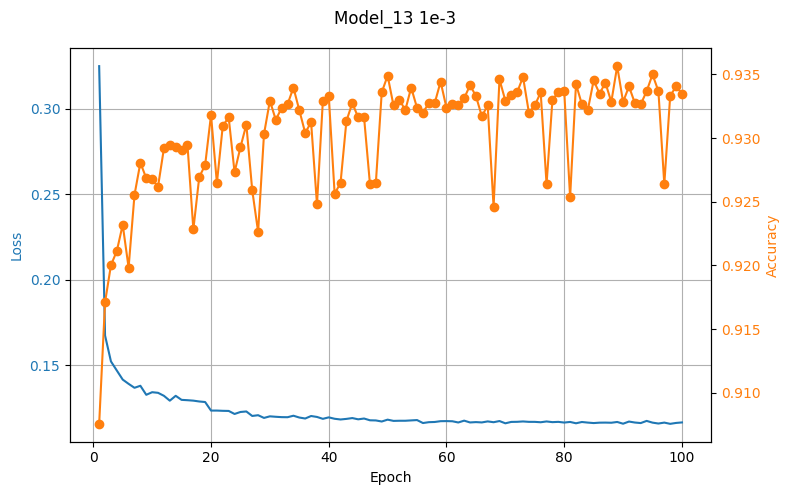

[W NNPACK.cpp:53] Could not initialize NNPACK! Reason: Unsupported hardware.



Model to test: Model_6 1e-3
feature_dim: 2048
lr=0.001 wd=0.0001 patience=5 factor=0.5 min_lr=1e-08 seed=0 batch=None


Epoch 16/100 loss=0.1456 val_acc=0.9179 best=0.9183:  16%|▏| 16/100 [1:42:10<8:5

Epoch 00016: reducing learning rate of group 0 to 5.0000e-04.


Epoch 54/100 loss=0.1285 val_acc=0.9319 best=0.9327:  54%|▌| 54/100 [5:41:48<4:5

Epoch 00054: reducing learning rate of group 0 to 2.5000e-04.


Epoch 60/100 loss=0.1238 val_acc=0.9226 best=0.9327:  60%|▌| 60/100 [6:19:40<4:1

Epoch 00060: reducing learning rate of group 0 to 1.2500e-04.


Epoch 72/100 loss=0.1245 val_acc=0.9303 best=0.9332:  72%|▋| 72/100 [7:35:02<2:5

Epoch 00072: reducing learning rate of group 0 to 6.2500e-05.


Epoch 78/100 loss=0.1224 val_acc=0.9316 best=0.9332:  78%|▊| 78/100 [8:13:08<2:1

Epoch 00078: reducing learning rate of group 0 to 3.1250e-05.


Epoch 89/100 loss=0.1228 val_acc=0.9327 best=0.9334:  89%|▉| 89/100 [9:22:44<1:0

Epoch 00089: reducing learning rate of group 0 to 1.5625e-05.


Epoch 95/100 loss=0.1225 val_acc=0.9316 best=0.9334:  95%|▉| 95/100 [10:01:07<31

Epoch 00095: reducing learning rate of group 0 to 7.8125e-06.


Epoch 100/100 loss=0.1223 val_acc=0.9323 best=0.9342: 100%|█| 100/100 [10:34:09<

Best val accuracy: 0.9341513675533908


Final TEST accuracy: 0.9361183964031472


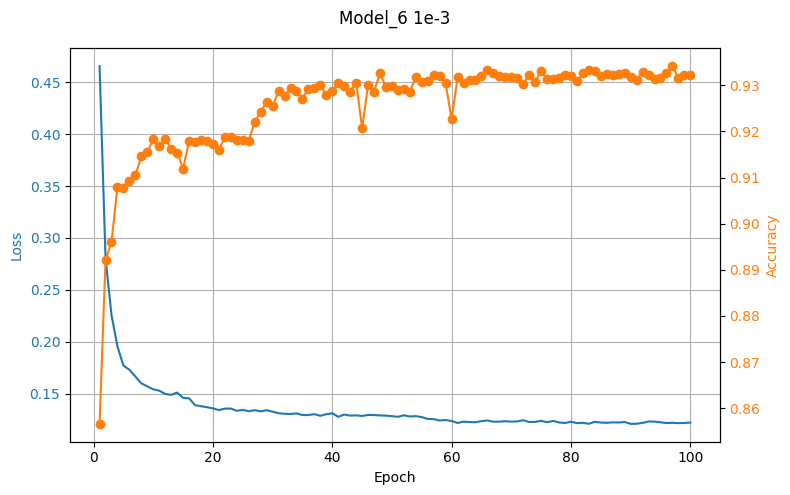


Model to test: Model_19 2e-3
feature_dim: 1536
lr=0.002 wd=0.0001 patience=5 factor=0.5 min_lr=1e-08 seed=0 batch=None


Epoch 12/100 loss=0.1481 val_acc=0.9137 best=0.9156:  12%| | 12/100 [52:12<6:20:

Epoch 00012: reducing learning rate of group 0 to 1.0000e-03.


Epoch 62/100 loss=0.1250 val_acc=0.9258 best=0.9307:  62%|▌| 62/100 [3:51:09<2:0

Epoch 00062: reducing learning rate of group 0 to 5.0000e-04.


Epoch 68/100 loss=0.1218 val_acc=0.9295 best=0.9307:  68%|▋| 68/100 [4:11:20<1:4

Epoch 00068: reducing learning rate of group 0 to 2.5000e-04.


Epoch 74/100 loss=0.1206 val_acc=0.9297 best=0.9307:  74%|▋| 74/100 [4:31:37<1:2

Epoch 00074: reducing learning rate of group 0 to 1.2500e-04.


Epoch 80/100 loss=0.1197 val_acc=0.9289 best=0.9307:  80%|▊| 80/100 [4:51:55<1:0

Epoch 00080: reducing learning rate of group 0 to 6.2500e-05.


Epoch 86/100 loss=0.1191 val_acc=0.9305 best=0.9307:  86%|▊| 86/100 [5:12:04<47:

Epoch 00086: reducing learning rate of group 0 to 3.1250e-05.


Epoch 92/100 loss=0.1195 val_acc=0.9302 best=0.9307:  92%|▉| 92/100 [5:32:20<27:

Epoch 00092: reducing learning rate of group 0 to 1.5625e-05.


Epoch 100/100 loss=0.1192 val_acc=0.9295 best=0.9308: 100%|█| 100/100 [5:59:24<0

Epoch 00100: reducing learning rate of group 0 to 7.8125e-06.
Best val accuracy: 0.9307793180966654


Final TEST accuracy: 0.9359310603222181


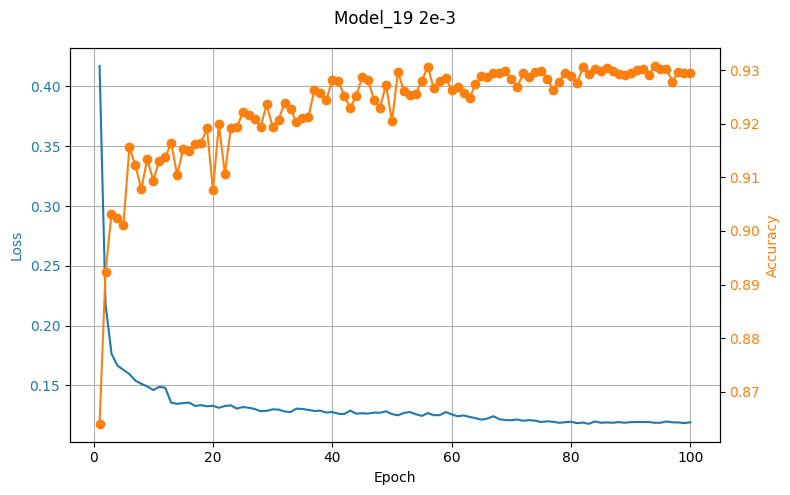


Model to test: M13_3_Extra1x1Late 5e-4
feature_dim: 16384
lr=0.0005 wd=0.0001 patience=5 factor=0.5 min_lr=1e-08 seed=0 batch=None


Epoch 31/100 loss=0.1280 val_acc=0.9233 best=0.9234:  31%|▎| 31/100 [3:45:54<8:2

Epoch 00031: reducing learning rate of group 0 to 2.5000e-04.


Epoch 49/100 loss=0.1207 val_acc=0.9260 best=0.9292:  49%|▍| 49/100 [5:57:13<6:1

Epoch 00049: reducing learning rate of group 0 to 1.2500e-04.


Epoch 55/100 loss=0.1185 val_acc=0.9268 best=0.9292:  55%|▌| 55/100 [6:41:16<5:2

Epoch 00055: reducing learning rate of group 0 to 6.2500e-05.


Epoch 64/100 loss=0.1178 val_acc=0.9291 best=0.9298:  64%|▋| 64/100 [7:46:57<4:2

Epoch 00064: reducing learning rate of group 0 to 3.1250e-05.


Epoch 70/100 loss=0.1166 val_acc=0.9287 best=0.9298:  70%|▋| 70/100 [8:31:27<3:4

Epoch 00070: reducing learning rate of group 0 to 1.5625e-05.


Epoch 77/100 loss=0.1173 val_acc=0.9300 best=0.9302:  77%|▊| 77/100 [9:23:35<2:5

Epoch 00077: reducing learning rate of group 0 to 7.8125e-06.


Epoch 89/100 loss=0.1171 val_acc=0.9308 best=0.9312:  89%|▉| 89/100 [10:52:53<1:

Epoch 00089: reducing learning rate of group 0 to 3.9063e-06.


Epoch 95/100 loss=0.1167 val_acc=0.9300 best=0.9312:  95%|▉| 95/100 [11:38:24<37

Epoch 00095: reducing learning rate of group 0 to 1.9531e-06.


Epoch 100/100 loss=0.1167 val_acc=0.9295 best=0.9312: 100%|█| 100/100 [12:15:48<

Best val accuracy: 0.9311539902585237


Final TEST accuracy: 0.9360247283626827


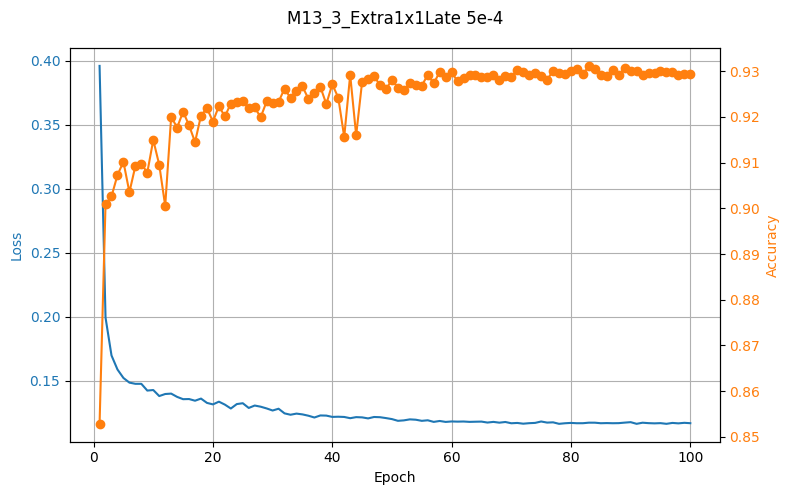


Model to test: M13_4_MorePoolBiggerFC 1e-3
feature_dim: 4096
lr=0.001 wd=0.0001 patience=5 factor=0.5 min_lr=1e-08 seed=0 batch=None


Epoch 27/100 loss=0.1250 val_acc=0.9290 best=0.9300:  27%|▎| 27/100 [3:38:22<10:

Epoch 00027: reducing learning rate of group 0 to 5.0000e-04.


Epoch 41/100 loss=0.1200 val_acc=0.9323 best=0.9329:  41%|▍| 41/100 [5:32:17<7:5

Epoch 00041: reducing learning rate of group 0 to 2.5000e-04.


Epoch 50/100 loss=0.1185 val_acc=0.9306 best=0.9338:  50%|▌| 50/100 [6:44:17<6:3

Epoch 00050: reducing learning rate of group 0 to 1.2500e-04.


Epoch 56/100 loss=0.1172 val_acc=0.9317 best=0.9338:  56%|▌| 56/100 [7:32:39<5:5

Epoch 00056: reducing learning rate of group 0 to 6.2500e-05.


Epoch 74/100 loss=0.1167 val_acc=0.9315 best=0.9344:  74%|▋| 74/100 [9:58:33<3:3

Epoch 00074: reducing learning rate of group 0 to 3.1250e-05.


Epoch 80/100 loss=0.1162 val_acc=0.9315 best=0.9344:  80%|▊| 80/100 [10:47:25<2:

Epoch 00080: reducing learning rate of group 0 to 1.5625e-05.


Epoch 89/100 loss=0.1162 val_acc=0.9329 best=0.9350:  89%|▉| 89/100 [12:00:53<1:

Epoch 00089: reducing learning rate of group 0 to 7.8125e-06.


Epoch 95/100 loss=0.1154 val_acc=0.9346 best=0.9350:  95%|▉| 95/100 [12:49:57<40

Epoch 00095: reducing learning rate of group 0 to 3.9063e-06.


Epoch 100/100 loss=0.1162 val_acc=0.9327 best=0.9350: 100%|█| 100/100 [13:31:12<

Best val accuracy: 0.9349943799175722


Final TEST accuracy: 0.9363994005245411


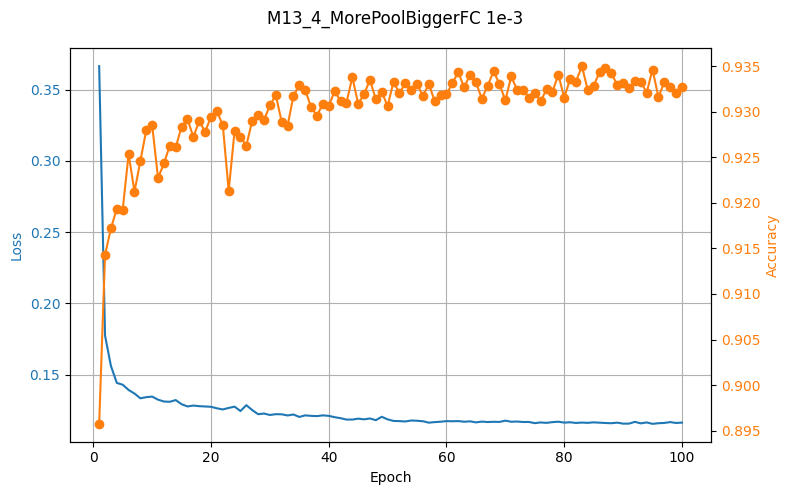

(0.9349943799175722, 0.9363994005245411)

In [49]:
# run_experiment(Model8_Bottleneck1x1, "Model_8", 100)
# run_experiment(Model9_VGGLite, "Model_9", 100)
# run_experiment(Model10_MorePooling, "Model_10", 100)
# run_experiment(Model11_CappedChannels, "Model_11", 100)
# run_experiment(Model12_ShrinkBeforeFC, "Model_12", 100)
# run_experiment(Model15_2conv_stages, "Model_15", 100)
# run_experiment(Model22_extra_conv_mid, "Model_22", 100)
# run_experiment(Model14_VGGmini_morepool, "Model_14", 100)
# run_experiment(Model21_late64, "Model_21", 100)
# run_experiment(Model20_all32, "Model_20", 100)
# run_experiment(Model13_VGGmini, "Model_13", 100)
# run_experiment(Model16_wide_early, "Model_16", 100)
# run_experiment(Model17_deeper_4blocks, "Model_17", 100)
# run_experiment(Model18_bigger_head, "Model_18", 100)
# run_experiment(Model19_lowchan_deeper, "Model_19", 100)
# run_experiment(M6_1_WiderEarly, "M6_1_WiderEarly", 100)
# run_experiment(M6_2_StrongerLate, "M6_2_StrongerLate", 100)
# run_experiment(M6_3_ExtraConvMid, "M6_3_ExtraConvMid", 100)
# run_experiment(M6_4_BiggerHead, "M6_4_BiggerHead", 100)
# run_experiment(M6_5_BottleneckMid, "M6_5_BottleneckMid", 100)
# run_experiment(M13_1_ExtraConvEarly, "M13_1_ExtraConvEarly", 100)
# run_experiment(M13_2_Wider, "M13_2_Wider", 100)
# run_experiment(M13_3_Extra1x1Late, "M13_3_Extra1x1Late", 100)
# run_experiment(M13_4_MorePoolBiggerFC, "M13_4_MorePoolBiggerFC", 100)
# run_experiment(M13_5_WithDropout, "M13_5_WithDropout", 100)
# run_experiment(M19_1_SlightlyWider, "M19_1_SlightlyWider", 100)
# run_experiment(M19_2_LastTo32, "M19_2_LastTo32", 100)
# run_experiment(M19_3_ExtraConvMid, "M19_3_ExtraConvMid", 100)
# run_experiment(M19_4_BottleneckBeforeC3, "M19_4_BottleneckBeforeC3", 100)
# run_experiment(M19_5_BiggerHead, "M19_5_BiggerHead", 100)

# LR VARIATION

# run_experiment_new(Model13_VGGmini, "Model_13 1e-3", 100, lr = 1e-3)
# run_experiment(Model13_VGGmini, "Model_13 1e-3", 100)

# run_experiment_new(Model13_VGGmini, "Model_13 3e-4", 100, lr = 3e-4)
# run_experiment_new(Model13_VGGmini, "Model_13 5e-4", 100, lr = 5e-4)
# run_experiment_new(Model13_VGGmini, "Model_13 2e-3", 100, lr = 2e-3)

# run_experiment_new(SmallKerasLikeQuantCNN, "Model_6 1e-3", 100, lr = 1e-3, min_lr = 1e-8)
# run_experiment(SmallKerasLikeQuantCNN, "Model_6 1e-3", 100)
# run_experiment_new(SmallKerasLikeQuantCNN, "Model_6 3e-4", 100, lr = 3e-4, min_lr = 1e-8)
# run_experiment_new(SmallKerasLikeQuantCNN, "Model_6 5e-4", 100, lr = 5e-4, min_lr = 1e-8)
# run_experiment_new(SmallKerasLikeQuantCNN, "Model_6 2e-3", 100, lr = 2e-3, min_lr = 1e-8)


# run_experiment_new(Model19_lowchan_deeper, "Model_19 1e-3", 100, lr = 1e-3, min_lr = 1e-8)
# run_experiment(Model19_lowchan_deeper, "Model_19 1e-3", 100)
# run_experiment_new(Model19_lowchan_deeper, "Model_19 3e-4", 100, lr = 3e-4, min_lr = 1e-8)
# run_experiment_new(Model19_lowchan_deeper, "Model_19 5e-4", 100, lr = 5e-4, min_lr = 1e-8)
# run_experiment_new(Model19_lowchan_deeper, "Model_19 2e-3", 100, lr = 2e-3, min_lr = 1e-8)


# run_experiment_new(M13_3_Extra1x1Late, "M13_3_Extra1x1Late 1e-3", 100, lr = 1e-3, min_lr = 1e-8)
# run_experiment(M13_3_Extra1x1Late, "M13_3_Extra1x1Late 1e-3", 100)
# run_experiment_new(M13_3_Extra1x1Late, "M13_3_Extra1x1Late 3e-4", 100, lr = 3e-4, min_lr = 1e-8)
# run_experiment_new(M13_3_Extra1x1Late, "M13_3_Extra1x1Late 5e-4", 100, lr = 5e-4, min_lr = 1e-8)
# run_experiment_new(M13_3_Extra1x1Late, "M13_3_Extra1x1Late 2e-3", 100, lr = 2e-3, min_lr = 1e-8)

# run_experiment_new(M13_4_MorePoolBiggerFC, "M13_4_MorePoolBiggerFC 1e-3", 100, lr = 1e-3, min_lr = 1e-8)
# run_experiment(M13_4_MorePoolBiggerFC, "M13_4_MorePoolBiggerFC 1e-3", 100)
# run_experiment_new(M13_4_MorePoolBiggerFC, "M13_4_MorePoolBiggerFC 3e-4", 100, lr = 3e-4, min_lr = 1e-8)
# run_experiment_new(M13_4_MorePoolBiggerFC, "M13_4_MorePoolBiggerFC 5e-4", 100, lr = 5e-4, min_lr = 1e-8)
# run_experiment_new(M13_4_MorePoolBiggerFC, "M13_4_MorePoolBiggerFC 2e-3", 100, lr = 2e-3, min_lr = 1e-8)

#### VARIATION OF OTHER PARAMETERS: WEIGHT DECAY, PATIENCE at a fixed BATCH SIZE = 16 

### KEEP THE BEST LR foreach Model 

# ### MODEL 13: Best LR: 1e-3 

# run_experiment_new(Model13_VGGmini, "Model_13 LR: 1e-3, WD: 0, Patience: 2", 100, lr = 1e-3, min_lr = 1e-10, weight_decay = 0, patience = 2)
# run_experiment_new(Model13_VGGmini, "Model_13 LR: 1e-3, WD: 1e-5, Patience: 2", 100, lr = 1e-3, min_lr = 1e-10, weight_decay = 1e-5, patience = 2)
# run_experiment_new(Model13_VGGmini, "Model_13 LR: 1e-3, WD: 5e-5, Patience: 2", 100, lr = 1e-3, min_lr = 1e-10, weight_decay = 5e-5, patience = 2)
# run_experiment_new(Model13_VGGmini, "Model_13 LR: 1e-3, WD: 1e-4, Patience: 2", 100, lr = 1e-3, min_lr = 1e-10, weight_decay = 1e-4, patience = 2)
# run_experiment_new(Model13_VGGmini, "Model_13 LR: 1e-3, WD: 5e-4, Patience: 2", 100, lr = 1e-3, min_lr = 1e-10, weight_decay = 5e-4, patience = 2)

# run_experiment_new(Model13_VGGmini, "Model_13 LR: 1e-3, WD: 0, Patience: 5", 100, lr = 1e-3, min_lr = 1e-10, weight_decay = 0, patience = 5)
# run_experiment_new(Model13_VGGmini, "Model_13 LR: 1e-3, WD: 1e-5, Patience: 5", 100, lr = 1e-3, min_lr = 1e-10, weight_decay = 1e-5, patience = 5)
# run_experiment_new(Model13_VGGmini, "Model_13 LR: 1e-3, WD: 5e-5, Patience: 5", 100, lr = 1e-3, min_lr = 1e-10, weight_decay = 5e-5, patience = 5)
# run_experiment_new(Model13_VGGmini, "Model_13 LR: 1e-3, WD: 1e-4, Patience: 5", 100, lr = 1e-3, min_lr = 1e-10, weight_decay = 1e-4, patience = 5)
# run_experiment_new(Model13_VGGmini, "Model_13 LR: 1e-3, WD: 5e-4, Patience: 5", 100, lr = 1e-3, min_lr = 1e-10, weight_decay = 5e-4, patience = 5)

# run_experiment_new(Model13_VGGmini, "Model_13 LR: 1e-3, WD: 0, Patience: 10", 100, lr = 1e-3, min_lr = 1e-10, weight_decay = 0, patience = 10)
# run_experiment_new(Model13_VGGmini, "Model_13 LR: 1e-3, WD: 1e-5, Patience: 10", 100, lr = 1e-3, min_lr = 1e-10, weight_decay = 1e-5, patience = 10)
# run_experiment_new(Model13_VGGmini, "Model_13 LR: 1e-3, WD: 5e-5, Patience: 10", 100, lr = 1e-3, min_lr = 1e-10, weight_decay = 5e-5, patience = 10)
# run_experiment_new(Model13_VGGmini, "Model_13 LR: 1e-3, WD: 1e-4, Patience: 10", 100, lr = 1e-3, min_lr = 1e-10, weight_decay = 1e-4, patience = 10)
# run_experiment_new(Model13_VGGmini, "Model_13 LR: 1e-3, WD: 5e-4, Patience: 10", 100, lr = 1e-3, min_lr = 1e-10, weight_decay = 5e-4, patience = 10)

# run_experiment_new(Model13_VGGmini, "Model_13 LR: 1e-3, WD: 0, Patience: 15", 100, lr = 1e-3, min_lr = 1e-10, weight_decay = 0, patience = 15)
# run_experiment_new(Model13_VGGmini, "Model_13 LR: 1e-3, WD: 1e-5, Patience: 15", 100, lr = 1e-3, min_lr = 1e-10, weight_decay = 1e-5, patience = 15)
# run_experiment_new(Model13_VGGmini, "Model_13 LR: 1e-3, WD: 5e-5, Patience: 15", 100, lr = 1e-3, min_lr = 1e-10, weight_decay = 5e-5, patience = 15)
# run_experiment_new(Model13_VGGmini, "Model_13 LR: 1e-3, WD: 1e-4, Patience: 15", 100, lr = 1e-3, min_lr = 1e-10, weight_decay = 1e-4, patience = 15)
# run_experiment_new(Model13_VGGmini, "Model_13 LR: 1e-3, WD: 5e-4, Patience: 15", 100, lr = 1e-3, min_lr = 1e-10, weight_decay = 5e-4, patience = 15)

# ### MODEL 6: Best LR: 1e-3 

# run_experiment_new(SmallKerasLikeQuantCNN, "Model_6 LR: 1e-3, WD: 0, Patience: 2", 100, lr = 1e-3, min_lr = 1e-10, weight_decay = 0, patience = 2)
# run_experiment_new(SmallKerasLikeQuantCNN, "Model_6 LR: 1e-3, WD: 1e-5, Patience: 2", 100, lr = 1e-3, min_lr = 1e-10, weight_decay = 1e-5, patience = 2)
# run_experiment_new(SmallKerasLikeQuantCNN, "Model_6 LR: 1e-3, WD: 5e-5, Patience: 2", 100, lr = 1e-3, min_lr = 1e-10, weight_decay = 5e-5, patience = 2)
# run_experiment_new(SmallKerasLikeQuantCNN, "Model_6 LR: 1e-3, WD: 1e-4, Patience: 2", 100, lr = 1e-3, min_lr = 1e-10, weight_decay = 1e-4, patience = 2)
# run_experiment_new(SmallKerasLikeQuantCNN, "Model_6 LR: 1e-3, WD: 5e-4, Patience: 2", 100, lr = 1e-3, min_lr = 1e-10, weight_decay = 5e-4, patience = 2)

# run_experiment_new(SmallKerasLikeQuantCNN, "Model_6 LR: 1e-3, WD: 0, Patience: 5", 100, lr = 1e-3, min_lr = 1e-10, weight_decay = 0, patience = 5)
# run_experiment_new(SmallKerasLikeQuantCNN, "Model_6 LR: 1e-3, WD: 1e-5, Patience: 5", 100, lr = 1e-3, min_lr = 1e-10, weight_decay = 1e-5, patience = 5)
# run_experiment_new(SmallKerasLikeQuantCNN, "Model_6 LR: 1e-3, WD: 5e-5, Patience: 5", 100, lr = 1e-3, min_lr = 1e-10, weight_decay = 5e-5, patience = 5)
# run_experiment_new(SmallKerasLikeQuantCNN, "Model_6 LR: 1e-3, WD: 1e-4, Patience: 5", 100, lr = 1e-3, min_lr = 1e-10, weight_decay = 1e-4, patience = 5)
# run_experiment_new(SmallKerasLikeQuantCNN, "Model_6 LR: 1e-3, WD: 5e-4, Patience: 5", 100, lr = 1e-3, min_lr = 1e-10, weight_decay = 5e-4, patience = 5)

# run_experiment_new(SmallKerasLikeQuantCNN, "Model_6 LR: 1e-3, WD: 0, Patience: 10", 100, lr = 1e-3, min_lr = 1e-10, weight_decay = 0, patience = 10)
# run_experiment_new(SmallKerasLikeQuantCNN, "Model_6 LR: 1e-3, WD: 1e-5, Patience: 10", 100, lr = 1e-3, min_lr = 1e-10, weight_decay = 1e-5, patience = 10)
# run_experiment_new(SmallKerasLikeQuantCNN, "Model_6 LR: 1e-3, WD: 5e-5, Patience: 10", 100, lr = 1e-3, min_lr = 1e-10, weight_decay = 5e-5, patience = 10)
# run_experiment_new(SmallKerasLikeQuantCNN, "Model_6 LR: 1e-3, WD: 1e-4, Patience: 10", 100, lr = 1e-3, min_lr = 1e-10, weight_decay = 1e-4, patience = 10)
# run_experiment_new(SmallKerasLikeQuantCNN, "Model_6 LR: 1e-3, WD: 5e-4, Patience: 10", 100, lr = 1e-3, min_lr = 1e-10, weight_decay = 5e-4, patience = 10)

# run_experiment_new(SmallKerasLikeQuantCNN, "Model_6 LR: 1e-3, WD: 0, Patience: 15", 100, lr = 1e-3, min_lr = 1e-10, weight_decay = 0, patience = 15)
# run_experiment_new(SmallKerasLikeQuantCNN, "Model_6 LR: 1e-3, WD: 1e-5, Patience: 15", 100, lr = 1e-3, min_lr = 1e-10, weight_decay = 1e-5, patience = 15)
# run_experiment_new(SmallKerasLikeQuantCNN, "Model_6 LR: 1e-3, WD: 5e-5, Patience: 15", 100, lr = 1e-3, min_lr = 1e-10, weight_decay = 5e-5, patience = 15)
# run_experiment_new(SmallKerasLikeQuantCNN, "Model_6 LR: 1e-3, WD: 1e-4, Patience: 15", 100, lr = 1e-3, min_lr = 1e-10, weight_decay = 1e-4, patience = 15)
# run_experiment_new(SmallKerasLikeQuantCNN, "Model_6 LR: 1e-3, WD: 5e-4, Patience: 15", 100, lr = 1e-3, min_lr = 1e-10, weight_decay = 5e-4, patience = 15)

# ### MODEL 19: Best LR: 2e-3 

# run_experiment_new(Model19_lowchan_deeper, "Model_19 LR: 2e-3, WD: 0, Patience: 2", 100, lr = 2e-3, min_lr = 1e-10, weight_decay = 0, patience = 2)
# run_experiment_new(Model19_lowchan_deeper, "Model_19 LR: 2e-3, WD: 1e-5, Patience: 2", 100, lr = 2e-3, min_lr = 1e-10, weight_decay = 1e-5, patience = 2)
# run_experiment_new(Model19_lowchan_deeper, "Model_19 LR: 2e-3, WD: 5e-5, Patience: 2", 100, lr = 2e-3, min_lr = 1e-10, weight_decay = 5e-5, patience = 2)
# run_experiment_new(Model19_lowchan_deeper, "Model_19 LR: 2e-3, WD: 1e-4, Patience: 2", 100, lr = 2e-3, min_lr = 1e-10, weight_decay = 1e-4, patience = 2)
# run_experiment_new(Model19_lowchan_deeper, "Model_19 LR: 2e-3, WD: 5e-4, Patience: 2", 100, lr = 2e-3, min_lr = 1e-10, weight_decay = 5e-4, patience = 2)

# run_experiment_new(Model19_lowchan_deeper, "Model_19 LR: 2e-3, WD: 0, Patience: 5", 100, lr = 2e-3, min_lr = 1e-10, weight_decay = 0, patience = 5)
# run_experiment_new(Model19_lowchan_deeper, "Model_19 LR: 2e-3, WD: 1e-5, Patience: 5", 100, lr = 2e-3, min_lr = 1e-10, weight_decay = 1e-5, patience = 5)
# run_experiment_new(Model19_lowchan_deeper, "Model_19 LR: 2e-3, WD: 5e-5, Patience: 5", 100, lr = 2e-3, min_lr = 1e-10, weight_decay = 5e-5, patience = 5)
# run_experiment_new(Model19_lowchan_deeper, "Model_19 LR: 2e-3, WD: 1e-4, Patience: 5", 100, lr = 2e-3, min_lr = 1e-10, weight_decay = 1e-4, patience = 5)
# run_experiment_new(Model19_lowchan_deeper, "Model_19 LR: 2e-3, WD: 5e-4, Patience: 5", 100, lr = 2e-3, min_lr = 1e-10, weight_decay = 5e-4, patience = 5)

# run_experiment_new(Model19_lowchan_deeper, "Model_19 LR: 2e-3, WD: 0, Patience: 10", 100, lr = 2e-3, min_lr = 1e-10, weight_decay = 0, patience = 10)
# run_experiment_new(Model19_lowchan_deeper, "Model_19 LR: 2e-3, WD: 1e-5, Patience: 10", 100, lr = 2e-3, min_lr = 1e-10, weight_decay = 1e-5, patience = 10)
# run_experiment_new(Model19_lowchan_deeper, "Model_19 LR: 2e-3, WD: 5e-5, Patience: 10", 100, lr = 2e-3, min_lr = 1e-10, weight_decay = 5e-5, patience = 10)
# run_experiment_new(Model19_lowchan_deeper, "Model_19 LR: 2e-3, WD: 1e-4, Patience: 10", 100, lr = 2e-3, min_lr = 1e-10, weight_decay = 1e-4, patience = 10)
# run_experiment_new(Model19_lowchan_deeper, "Model_19 LR: 2e-3, WD: 5e-4, Patience: 10", 100, lr = 2e-3, min_lr = 1e-10, weight_decay = 5e-4, patience = 10)

# run_experiment_new(Model19_lowchan_deeper, "Model_19 LR: 2e-3, WD: 0, Patience: 15", 100, lr = 2e-3, min_lr = 1e-10, weight_decay = 0, patience = 15)
# run_experiment_new(Model19_lowchan_deeper, "Model_19 LR: 2e-3, WD: 1e-5, Patience: 15", 100, lr = 2e-3, min_lr = 1e-10, weight_decay = 1e-5, patience = 15)
# run_experiment_new(Model19_lowchan_deeper, "Model_19 LR: 2e-3, WD: 5e-5, Patience: 15", 100, lr = 2e-3, min_lr = 1e-10, weight_decay = 5e-5, patience = 15)
# run_experiment_new(Model19_lowchan_deeper, "Model_19 LR: 2e-3, WD: 1e-4, Patience: 15", 100, lr = 2e-3, min_lr = 1e-10, weight_decay = 1e-4, patience = 15)
# run_experiment_new(Model19_lowchan_deeper, "Model_19 LR: 2e-3, WD: 5e-4, Patience: 15", 100, lr = 2e-3, min_lr = 1e-10, weight_decay = 5e-4, patience = 15)

# ### MODEL 13_3: Best LR: 5e-4 

# run_experiment_new(M13_3_Extra1x1Late, "Model_13_3 LR: 5e-4, WD: 0, Patience: 2", 100, lr = 5e-4, min_lr = 1e-10, weight_decay = 0, patience = 2)
# run_experiment_new(M13_3_Extra1x1Late, "Model_13_3 LR: 5e-4, WD: 1e-5, Patience: 2", 100, lr = 5e-4, min_lr = 1e-10, weight_decay = 1e-5, patience = 2)
# run_experiment_new(M13_3_Extra1x1Late, "Model_13_3 LR: 5e-4, WD: 5e-5, Patience: 2", 100, lr = 5e-4, min_lr = 1e-10, weight_decay = 5e-5, patience = 2)
# run_experiment_new(M13_3_Extra1x1Late, "Model_13_3 LR: 5e-4, WD: 1e-4, Patience: 2", 100, lr = 5e-4, min_lr = 1e-10, weight_decay = 1e-4, patience = 2)
# run_experiment_new(M13_3_Extra1x1Late, "Model_13_3 LR: 5e-4, WD: 5e-4, Patience: 2", 100, lr = 5e-4, min_lr = 1e-10, weight_decay = 5e-4, patience = 2)

# run_experiment_new(M13_3_Extra1x1Late, "Model_13_3 LR: 5e-4, WD: 0, Patience: 5", 100, lr = 5e-4, min_lr = 1e-10, weight_decay = 0, patience = 5)
# run_experiment_new(M13_3_Extra1x1Late, "Model_13_3 LR: 5e-4, WD: 1e-5, Patience: 5", 100, lr = 5e-4, min_lr = 1e-10, weight_decay = 1e-5, patience = 5)
# run_experiment_new(M13_3_Extra1x1Late, "Model_13_3 LR: 5e-4, WD: 5e-5, Patience: 5", 100, lr = 5e-4, min_lr = 1e-10, weight_decay = 5e-5, patience = 5)
# run_experiment_new(M13_3_Extra1x1Late, "Model_13_3 LR: 5e-4, WD: 1e-4, Patience: 5", 100, lr = 5e-4, min_lr = 1e-10, weight_decay = 1e-4, patience = 5)
# run_experiment_new(M13_3_Extra1x1Late, "Model_13_3 LR: 5e-4, WD: 5e-4, Patience: 5", 100, lr = 5e-4, min_lr = 1e-10, weight_decay = 5e-4, patience = 5)

# run_experiment_new(M13_3_Extra1x1Late, "Model_13_3 LR: 5e-4, WD: 0, Patience: 10", 100, lr = 5e-4, min_lr = 1e-10, weight_decay = 0, patience = 10)
# run_experiment_new(M13_3_Extra1x1Late, "Model_13_3 LR: 5e-4, WD: 1e-5, Patience: 10", 100, lr = 5e-4, min_lr = 1e-10, weight_decay = 1e-5, patience = 10)
# run_experiment_new(M13_3_Extra1x1Late, "Model_13_3 LR: 5e-4, WD: 5e-5, Patience: 10", 100, lr = 5e-4, min_lr = 1e-10, weight_decay = 5e-5, patience = 10)
# run_experiment_new(M13_3_Extra1x1Late, "Model_13_3 LR: 5e-4, WD: 1e-4, Patience: 10", 100, lr = 5e-4, min_lr = 1e-10, weight_decay = 1e-4, patience = 10)
# run_experiment_new(M13_3_Extra1x1Late, "Model_13_3 LR: 5e-4, WD: 5e-4, Patience: 10", 100, lr = 5e-4, min_lr = 1e-10, weight_decay = 5e-4, patience = 10)

# run_experiment_new(M13_3_Extra1x1Late, "Model_13_3 LR: 5e-4, WD: 0, Patience: 15", 100, lr = 5e-4, min_lr = 1e-10, weight_decay = 0, patience = 15)
# run_experiment_new(M13_3_Extra1x1Late, "Model_13_3 LR: 5e-4, WD: 1e-5, Patience: 15", 100, lr = 5e-4, min_lr = 1e-10, weight_decay = 1e-5, patience = 15)
# run_experiment_new(M13_3_Extra1x1Late, "Model_13_3 LR: 5e-4, WD: 5e-5, Patience: 15", 100, lr = 5e-4, min_lr = 1e-10, weight_decay = 5e-5, patience = 15)
# run_experiment_new(M13_3_Extra1x1Late, "Model_13_3 LR: 5e-4, WD: 1e-4, Patience: 15", 100, lr = 5e-4, min_lr = 1e-10, weight_decay = 1e-4, patience = 15)
# run_experiment_new(M13_3_Extra1x1Late, "Model_13_3 LR: 5e-4, WD: 5e-4, Patience: 15", 100, lr = 5e-4, min_lr = 1e-10, weight_decay = 5e-4, patience = 15)

# ### MODEL 13_4: Best LR: 1e-3 

# run_experiment_new(M13_4_MorePoolBiggerFC, "Model_13_4 LR: 1e-3, WD: 0, Patience: 2", 100, lr = 1e-3, min_lr = 1e-10, weight_decay = 0, patience = 2)
# run_experiment_new(M13_4_MorePoolBiggerFC, "Model_13_4 LR: 1e-3, WD: 1e-5, Patience: 2", 100, lr = 1e-3, min_lr = 1e-10, weight_decay = 1e-5, patience = 2)
# run_experiment_new(M13_4_MorePoolBiggerFC, "Model_13_4 LR: 1e-3, WD: 5e-5, Patience: 2", 100, lr = 1e-3, min_lr = 1e-10, weight_decay = 5e-5, patience = 2)
# run_experiment_new(M13_4_MorePoolBiggerFC, "Model_13_4 LR: 1e-3, WD: 1e-4, Patience: 2", 100, lr = 1e-3, min_lr = 1e-10, weight_decay = 1e-4, patience = 2)
# run_experiment_new(M13_4_MorePoolBiggerFC, "Model_13_4 LR: 1e-3, WD: 5e-4, Patience: 2", 100, lr = 1e-3, min_lr = 1e-10, weight_decay = 5e-4, patience = 2)

# run_experiment_new(M13_4_MorePoolBiggerFC, "Model_13_4 LR: 1e-3, WD: 0, Patience: 5", 100, lr = 1e-3, min_lr = 1e-10, weight_decay = 0, patience = 5)
# run_experiment_new(M13_4_MorePoolBiggerFC, "Model_13_4 LR: 1e-3, WD: 1e-5, Patience: 5", 100, lr = 1e-3, min_lr = 1e-10, weight_decay = 1e-5, patience = 5)
# run_experiment_new(M13_4_MorePoolBiggerFC, "Model_13_4 LR: 1e-3, WD: 5e-5, Patience: 5", 100, lr = 1e-3, min_lr = 1e-10, weight_decay = 5e-5, patience = 5)
# run_experiment_new(M13_4_MorePoolBiggerFC, "Model_13_4 LR: 1e-3, WD: 1e-4, Patience: 5", 100, lr = 1e-3, min_lr = 1e-10, weight_decay = 1e-4, patience = 5)
# run_experiment_new(M13_4_MorePoolBiggerFC, "Model_13_4 LR: 1e-3, WD: 5e-4, Patience: 5", 100, lr = 1e-3, min_lr = 1e-10, weight_decay = 5e-4, patience = 5)

# run_experiment_new(M13_4_MorePoolBiggerFC, "Model_13_4 LR: 1e-3, WD: 0, Patience: 10", 100, lr = 1e-3, min_lr = 1e-10, weight_decay = 0, patience = 10)
# run_experiment_new(M13_4_MorePoolBiggerFC, "Model_13_4 LR: 1e-3, WD: 1e-5, Patience: 10", 100, lr = 1e-3, min_lr = 1e-10, weight_decay = 1e-5, patience = 10)
# run_experiment_new(M13_4_MorePoolBiggerFC, "Model_13_4 LR: 1e-3, WD: 5e-5, Patience: 10", 100, lr = 1e-3, min_lr = 1e-10, weight_decay = 5e-5, patience = 10)
# run_experiment_new(M13_4_MorePoolBiggerFC, "Model_13_4 LR: 1e-3, WD: 1e-4, Patience: 10", 100, lr = 1e-3, min_lr = 1e-10, weight_decay = 1e-4, patience = 10)
# run_experiment_new(M13_4_MorePoolBiggerFC, "Model_13_4 LR: 1e-3, WD: 5e-4, Patience: 10", 100, lr = 1e-3, min_lr = 1e-10, weight_decay = 5e-4, patience = 10)

# run_experiment_new(M13_4_MorePoolBiggerFC, "Model_13_4 LR: 1e-3, WD: 0, Patience: 15", 100, lr = 1e-3, min_lr = 1e-10, weight_decay = 0, patience = 15)
# run_experiment_new(M13_4_MorePoolBiggerFC, "Model_13_4 LR: 1e-3, WD: 1e-5, Patience: 15", 100, lr = 1e-3, min_lr = 1e-10, weight_decay = 1e-5, patience = 15)
# run_experiment_new(M13_4_MorePoolBiggerFC, "Model_13_4 LR: 1e-3, WD: 5e-5, Patience: 15", 100, lr = 1e-3, min_lr = 1e-10, weight_decay = 5e-5, patience = 15)
# run_experiment_new(M13_4_MorePoolBiggerFC, "Model_13_4 LR: 1e-3, WD: 1e-4, Patience: 15", 100, lr = 1e-3, min_lr = 1e-10, weight_decay = 1e-4, patience = 15)
# run_experiment_new(M13_4_MorePoolBiggerFC, "Model_13_4 LR: 1e-3, WD: 5e-4, Patience: 15", 100, lr = 1e-3, min_lr = 1e-10, weight_decay = 5e-4, patience = 15)

# TRAIN WITH THE NEW DATASET and Other Augmentation for dataset

# run_experiment_new(Model13_VGGmini(w_bit = 2, a_bit = 2), "Model_13 1e-3", 100, lr = 1e-3, min_lr = 1e-8)
# run_experiment_new(SmallKerasLikeQuantCNN(w_bit = 2, a_bit = 2), "Model_6 1e-3", 100, lr = 1e-3, min_lr = 1e-8)
# run_experiment_new(Model19_lowchan_deeper(w_bit = 2, a_bit = 2), "Model_19 2e-3", 100, lr = 2e-3, min_lr = 1e-8)
# run_experiment_new(M13_3_Extra1x1Late(w_bit = 2, a_bit = 2), "M13_3_Extra1x1Late 5e-4", 100, lr = 5e-4, min_lr = 1e-8)
# run_experiment_new(M13_4_MorePoolBiggerFC(w_bit = 2, a_bit = 2), "M13_4_MorePoolBiggerFC 1e-3", 100, lr = 1e-3, min_lr = 1e-8)

run_experiment_new(Model13_VGGmini, "Model_13 1e-3", 100, lr = 1e-3, min_lr = 1e-8)
run_experiment_new(SmallKerasLikeQuantCNN, "Model_6 1e-3", 100, lr = 1e-3, min_lr = 1e-8)
run_experiment_new(Model19_lowchan_deeper, "Model_19 2e-3", 100, lr = 2e-3, min_lr = 1e-8)
run_experiment_new(M13_3_Extra1x1Late, "M13_3_Extra1x1Late 5e-4", 100, lr = 5e-4, min_lr = 1e-8)
run_experiment_new(M13_4_MorePoolBiggerFC, "M13_4_MorePoolBiggerFC 1e-3", 100, lr = 1e-3, min_lr = 1e-8)



# run_experiment_new(Model8_Bottleneck1x1, "Model_8", 100, lr = 1e-3, min_lr = 1e-8)

# run_experiment_new(Model11_CappedChannels, "Model_11", 100, lr = 1e-3, min_lr = 1e-8)

# run_experiment_new(Model22_extra_conv_mid, "Model_22", 100, lr = 1e-3, min_lr = 1e-8)

# run_experiment_new(Model14_VGGmini_morepool, "Model_14", 100, lr = 1e-3, min_lr = 1e-8)

# run_experiment_new(Model20_all32, "Model_20", 100, lr = 1e-3, min_lr = 1e-8)
